# Problem Defition

**Modatta** is a mobile app that aims at giving users the power over their personal data while allowing marketers to get access to **consented data** about their targeted audience.

With this project, our goal is to help Modatta to **recommend** the insights and offers that the users are most likely to have interest in. For that, we will start by building a **Deep Interest Network (DIN)** model, then trying two more different models - **Deep Factorization-Machine (DeepFM)** and **Extreme Deep Factorization-Machine (xDeepFM)** - to find out which one works the best.

We will then follow two different approaches:
- The first one consists of **directly recommending** the insights or the categories of insights to modatta users as individuals, by directly applying the model and making predictions.
- In the second approach, we are getting a **representation of users** with the embedding weights and using this information, along with the users' profile data, to represent the users in clusters. Then the recommendations can be done based on the similarity between the users within the same cluster.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, load_model
from deepctr.models import DIN, DeepFM, xDeepFM
from deepctr.inputs import SparseFeat,VarLenSparseFeat,DenseFeat,get_feature_names
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras import utils
import tensorflow.keras as keras
import tensorflow as tf
import warnings
#import pandas_profiling 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact
# from IPython.display import display
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
#class to select columns from a pandas df to which a certain function will be applied inside the pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [4]:
#class to apply a function to a pandas df and return that df after transformation

class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

DeepCTR version 0.9.0 detected. Your version is 0.7.4.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.9.0


## Loading the synthetic datasets, including Emila's data

As we are working on a data privacy basis, we don't have access to moddata users' data, so we need to create synthetic data and work with this to build our models.

### Insight features

In this section, we will load the `insight_dic`, `insight_cat_dic` and `insight_features_df` data. Take a look at the Data Generation notebook to see how these datasets were created.

- **insight_dic:** dictionary for the insights data, where each insight_id is assigned to its correspondent label
- **insight_cat_dic:** dictionary for the insights' categories data, where each cat_id is assigned to its correspondent label
- **insight_features_df:** dataset with each insight_id assigned to its correspondent category

#### Loading generated insights data:

In [5]:
insight_dic = pd.read_csv("../data/processed/insight_dic.csv").set_index("insight_id")
insight_cat_dic = pd.read_csv("../data/processed/insight_cat_dic.csv").set_index("cat_id")
insight_features_df = pd.read_csv("../data/processed/insight_features.csv").drop("Unnamed: 0", axis = 1)

In [6]:
insight_features_df

insight_id  cat_id
0              0      15
1              1      59
2              2       0
3              3      58
4              4      58
...          ...     ...
1559        1559      83
1560        1560       7
1561        1561       7
1562        1562      75
1563        1563      54

[1564 rows x 2 columns]

### User profile features

In this section, we will load the `labeled_user_profiles`, `labeled_new_profiles`, `user_profile_df`, `new_profiles_df` and the `final_profile_df` data. Take a look at the Data Generation notebook to see how these datasets were created.

- **labeled_user_profiles:** synthetic data created to represent 10000 users with random profile data. This dataframe contains the labeled data.
- **user_profile_df:** labeled_user_profiles with the labels transformed into codes, so that it can be easily read by the model later on.
- **labeled_new_profiles:** real data that comes from a new profile (in this case, we are using one of ours (Carolina's). This dataframe contains the labeled data.
- **new_profiles_df:** labeled_new_profiles with the labels transformed into codes, so that it can be easily read by the model later on.
- **final_profile_df:** user_profile_df merged with the new_profiles_df

#### Loading generated profile data:

In [88]:
final_profile_df = pd.read_csv("../data/processed/final_profile.csv").drop("Unnamed: 0", axis = 1)

In [89]:
final_profile_df

user_id  Birth_year  Gender  Civil_status  Degree  Professional_status  \
0            0           1       0             1       3                    6   
1            1           7       1             1       5                    1   
2            2           0       0             2       3                    6   
3            3           4       1             1       4                    4   
4            4           0       0             2       5                    1   
...        ...         ...     ...           ...     ...                  ...   
9996      9996           2       1             3       1                    1   
9997      9997           3       0             1       3                    1   
9998      9998           7       0             0       5                    2   
9999      9999           1       0             1       4                    6   
10000    10000           6       1             2       3                    1   

       Annual_income  Practice_sports  
0                  5                1  
1                  1                1  
2                  5                0  
3                  2                1  
4                  4                1  
...              ...              ...  
9996               2                0  
9997               1                0  
9998               4                1  
9999               2                0  
10000              0                1  

[10001 rows x 8 columns]

### User behaviours:

In this section, we will load the user behaviours final dataset, which represents the association between the users and the insights. When building this dataframe, each user (previously created and stored with a unique user_id) has some insights associated and a value saying if:

- the user is really interested in the insight: **True**
- the user is not interested in the insight: **False**
- we don't have information about whether or not the user is interested: **Unknown**

Initially, two dataframes were generated, `user_behaviours_df`, `new_users_behaviour`, and then merged into a single dataset, `final_user_behaviour`. Take a look at the Data Generation notebook to see how these datasets were created.

- **user_behaviours_df:** synthetic data created to represent 1000000 "behaviours" for the 10000 created users - 1000000 interactions between a user and an insight.
- **new_users_behaviour:** real data that comes from a new profile (in this case, we are using one of ours (Carolina's). This df will have information about which insights the new user is interested in, is not interested at all and the insights we don't any have information about for the users.
- **final_behaviours_df:** user_behaviours_df merged with the new_users_behaviour data frame

#### Loading generated behaviours data:

In [8]:
final_behaviour_df = pd.read_csv("data/generated_data/final_behaviour.csv").drop("Unnamed: 0", axis = 1)

## Model

Let's start by reading the final dataset combining all the previously loaded ones, and the datasets that were used for training the model. Take a look at the Data Generation notebook to see how these datasets were created.

In [8]:
final_df = pd.read_csv("../data/processed/final_df.csv").drop("Unnamed: 0", axis = 1)
final_df

user_id  insight_id  True  False  Birth_year  Gender  Civil_status  \
0            235        1153     1      0           1       1             0   
1           6285        1153     1      0           3       0             3   
2            431        1153     1      0           5       0             3   
3           2244        1153     0      1           1       2             0   
4           1214        1153     1      0           0       1             3   
...          ...         ...   ...    ...         ...     ...           ...   
1001559     6690        1444     0      0           2       0             0   
1001560     5193        1444     1      0           1       0             3   
1001561     4211        1444     1      0           7       0             1   
1001562     2878        1444     1      0           8       2             3   
1001563    10000        1444     0      0           6       1             2   

         Degree  Professional_status  Annual_income  Practice_sports  cat_id  \
0             4                    2              0                1      63   
1             5                    4              3                0      63   
2             5                    4              1                0      63   
3             1                    2              2                0      63   
4             4                    0              1                0      63   
...         ...                  ...            ...              ...     ...   
1001559       5                    4              4                1      47   
1001560       5                    0              5                1      47   
1001561       6                    1              2                0      47   
1001562       0                    4              4                1      47   
1001563       3                    1              0                1      47   

         hist_cat_id  hist_insight_id  
0                 63             1153  
1                 63             1153  
2                 63             1153  
3                 63             1153  
4                 63             1153  
...              ...              ...  
1001559           47             1444  
1001560           47             1444  
1001561           47             1444  
1001562           47             1444  
1001563           47             1444  

[1001564 rows x 14 columns]

In [10]:
labeled_data = pd.read_csv("../data/processed/final_datasets/labeled_data.csv").drop("Unnamed: 0", axis = 1)
unlabeled_data = pd.read_csv("../data/processed/final_datasets/unlabeled_data.csv").drop("Unnamed: 0", axis = 1)
train = pd.read_csv("../data/processed/final_datasets/first_training_set.csv").drop("Unnamed: 0", axis = 1)
test = pd.read_csv("../data/processed/final_datasets/first_test_set.csv").drop("Unnamed: 0", axis = 1)

Now let's just run a few cells to get the x and y dataframes correctly displayed:

In [31]:
sparse_features = ["user_id", "insight_id", #"True",
                   "Birth_year", "Gender", "Civil_status", "Degree",
                   "Professional_status", "Annual_income", "Practice_sports", "cat_id"]
sequence_features = ['hist_cat_id', 'hist_insight_id']
behavior_feature_list = ['insight_id', 'cat_id']
target = ["True"]

In [32]:
vocabulary_size_sf = dict.fromkeys(sparse_features)

for column in final_df.columns:
    if column in vocabulary_size_sf.keys():
        vocabulary_size_sf[column] = final_df[column].nunique() + final_df[column].min()
        

vocabulary_size_sf["user_id"] += vocabulary_size_sf["user_id"]

In [33]:
vocabulary_size_vlsf = dict.fromkeys(sequence_features)

for column in final_df.columns:
    if column in vocabulary_size_vlsf.keys():
        vocabulary_size_vlsf[column] = final_df[column].nunique() + final_df[column].min()

In [34]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=vocabulary_size_sf[feat],embedding_dim=5) for feat in sparse_features] + [VarLenSparseFeat(SparseFeat(feat, vocabulary_size=vocabulary_size_vlsf[feat],embedding_dim=5), maxlen=1) for feat in sequence_features] #+ [DenseFeat(feat, 1, )for feat in dense_features] 
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns, )

In [35]:
x_train, y_train = {name:train[name] for name in feature_names}, {name:train[name] for name in target}
x_test, y_test = {name:test[name] for name in feature_names}, {name:test[name] for name in target}
x_unlabeled = {name:unlabeled_data[name] for name in feature_names}

This is how the `x_train` dataframe looks like:

In [36]:
pd.DataFrame(x_train)

user_id  insight_id  Birth_year  Gender  Civil_status  Degree  \
0          5787         327           8       1             0       0   
1          1184         743           4       0             3       0   
2          3488         423           2       0             1       2   
3          6665         878           8       1             2       6   
4           128         501           0       0             2       4   
...         ...         ...         ...     ...           ...     ...   
639987     1129        1077           4       1             1       1   
639988     3856        1264           6       0             3       1   
639989     1529         415           3       1             3       1   
639990     2840         737           0       0             0       5   
639991     4674         588           0       1             1       2   

        Professional_status  Annual_income  Practice_sports  cat_id  \
0                         3              2                1      37   
1                         3              3                1      45   
2                         3              0                1      37   
3                         5              2                1      16   
4                         3              0                1      37   
...                     ...            ...              ...     ...   
639987                    3              3                0      83   
639988                    3              3                1      85   
639989                    3              4                0      37   
639990                    2              4                1      45   
639991                    2              5                1      16   

        hist_cat_id  hist_insight_id  
0                37              327  
1                45              743  
2                37              423  
3                16              878  
4                37              501  
...             ...              ...  
639987           83             1077  
639988           85             1264  
639989           37              415  
639990           45              737  
639991           16              588  

[639992 rows x 12 columns]

In [37]:
print(len(pd.DataFrame(x_train).drop_duplicates(subset = "user_id", keep = "first")))
print(len(pd.DataFrame(x_test).drop_duplicates(subset = "user_id", keep = "first")))
print(len(pd.DataFrame(x_unlabeled).drop_duplicates(subset = "user_id", keep = "first")))

10001
10001
10001


10001 unique values for `user_id` in all of the `x_training`, `x_test` and `x_unlabeled` datasets

### Load Trained Model, Predict and Evaluate

This is how you can load the already trained DIN model:

In [38]:
from tensorflow.python.keras.models import save_model,load_model
from deepctr.layers import custom_objects

filename = 'first_approach_din_model.h5'

In [39]:
best_model = load_model("../models/" + filename,custom_objects)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_83/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_83/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_83/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_83/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


And next we present the evaluation of the model:

In [40]:
print("\033[1mTRAINING SET\033[0m")

y_train_pred = best_model.predict(x_train, batch_size=256)

#print(classification_report(train[target].values, y_train_pred))
print("LogLoss", log_loss(pd.DataFrame(y_train).values, y_train_pred))
print("AUC", roc_auc_score(pd.DataFrame(y_train).values, y_train_pred))

y_train_pred[y_train_pred>0.5] = 1
y_train_pred[y_train_pred<=0.5] = 0

print('Accuracy: ',accuracy_score(pd.DataFrame(y_train).values, y_train_pred))
print('Recall: ',recall_score(pd.DataFrame(y_train).values, y_train_pred))
print('Precision: ',precision_score(pd.DataFrame(y_train).values, y_train_pred))

TRAINING SET
LogLoss 0.6186986551831203
AUC 0.5462592221538517
Accuracy:  0.6963665170814635
Recall:  0.8777277587548314
Precision:  0.7568572581730122


In [41]:
print("\033[1mTEST SET\033[0m")

y_test_pred = best_model.predict(x_test, batch_size=256)

#print(classification_report(test[target].values, y_test_pred))
print("LogLoss", log_loss(pd.DataFrame(y_test).values, y_test_pred))
print("AUC", roc_auc_score(pd.DataFrame(y_test).values, y_test_pred))

y_test_pred[y_test_pred>0.5] = 1
y_test_pred[y_test_pred<=0.5] = 0

print('Accuracy: ',accuracy_score(pd.DataFrame(y_test).values, y_test_pred))
print('Recall: ',recall_score(pd.DataFrame(y_test).values, y_test_pred))
print('Precision: ',precision_score(pd.DataFrame(y_test).values, y_test_pred))

TEST SET
LogLoss 0.6202844384204033
AUC 0.5473628547469456
Accuracy:  0.6952105950662192
Recall:  0.8786972860125261
Precision:  0.7544886135490162


## First approach: Recommendation

In this section, a first approach was followed to get recommendations of new insights for the users. It approach consists of directly recommending some of the unknown insights to the users as individuals. For that, we need to predict the insights that each user is most likely to have interest in. Let's work with the **unlabeled** dataframe, which consists of the dataset with the insights that we don't have any information about for each user.

#### Emila's TRUE and FALSE insight categories:

In [42]:
labeled_data_with_cats = pd.merge(labeled_data, insight_cat_dic, on = "cat_id", how = "left")
Emma_labeled_data = labeled_data_with_cats.loc[labeled_data_with_cats.user_id == 10000]

Emma_true_cats = pd.DataFrame(Emma_labeled_data.loc[Emma_labeled_data["True"] == 1].drop_duplicates(subset = "category").sort_values("category").reset_index()["category"])
Emma_false_cats = pd.DataFrame(Emma_labeled_data.loc[Emma_labeled_data["False"] == 1].drop_duplicates(subset = "category").sort_values("category").reset_index()["category"])

In [43]:
for i in Emma_true_cats.category:
    print(i)

ARTS
BEAUTY AND PERSONAL CARE
COMEDY
COMMUNITY SERVICES
Community organisation
ENTERTAINMENT
FASHION
FOOD AND DRINK
GADGETS
HEALTH AND FITNESS
Interest
JOURNALISM
LITERATURE
NON PROFIT ORGANIZATION
Non-business places
Other
PHOTOGRAPHY
SCIENCE AND TECHNOLOGY
SHOPPING AND DEALS
SPORTS
TEACHING AND EDUCATION
TV


In [44]:
for i in Emma_false_cats.category:
    print(i)

ARMED FORCES


#### Applying the model to make predictions:

In [45]:
predictions = best_model.predict(x_unlabeled, batch_size=256)

In [46]:
print(len(predictions[predictions>=0.5]))
print(len(predictions[predictions<0.5]))

175418
26155


In [47]:
unlabeled_data['prob'] = predictions

#### Check if it's working to predict for a new user_id:

In [48]:
new_users = unlabeled_data.iloc[np.random.randint(0, 1000, 10)]
new_users["user_id"] = 10001
new_users

x_new_users = {name:new_users[name] for name in feature_names}

In [49]:
y_new_users = best_model.predict(x_new_users, batch_size=256)
y_new_users

array([[0.4530401 ],
       [0.4151151 ],
       [0.54430366],
       [0.7321279 ],
       [0.54865885],
       [0.65461123],
       [0.67838216],
       [0.58092093],
       [0.544213  ],
       [0.6321971 ]], dtype=float32)

### Recommending insights

In [50]:
recomend_item = unlabeled_data[['user_id','prob','insight_id','cat_id']]
recomend_item["recommend"] = np.where(recomend_item["prob"] >= 0.5, 1, 0)
recomend_item.head(10)

user_id      prob  insight_id  cat_id  recommend
0     6976  0.808430        1153      63          1
1     4946  0.734006        1153      63          1
2      732  0.846482        1153      63          1
3     5380  0.598829        1153      63          1
4     1106  0.682535        1153      63          1
5     8461  0.734234        1153      63          1
6     1775  0.625226        1153      63          1
7     7728  0.670970        1153      63          1
8     8518  0.730810        1153      63          1
9     8441  0.735883        1153      63          1

In [51]:
@interact

def insight_recom(user_id = (0, 10000, 1)):
    user_recom = recomend_item[(recomend_item.user_id == user_id)]
    user_recom_insights = pd.merge(user_recom, insight_dic, on = "insight_id", how = "left").sort_values("prob", ascending = False)
    user_recom_insights = pd.merge(user_recom_insights, insight_cat_dic, on = "cat_id", how = "left")
#     for insight in user_recom_insights.insight.head(20):
#         print(insight)
#     for cat in user_recom_insights.category.head(20):
#         print(cat)
    return user_recom_insights.head(20)

interactive(children=(IntSlider(value=5000, description='user_id', max=10000), Output()), _dom_classes=('widge…

### Recommending insights categories

In [52]:
insight_per_cat = insight_features_df.groupby("cat_id").count().rename(columns = {"insight_id":"n_insights"})
recomend_cat = unlabeled_data[['user_id','prob','insight_id','cat_id']]
recomend_cat = pd.DataFrame(pd.merge(recomend_cat.reset_index(), insight_per_cat, on = "cat_id", how = "left").groupby(["user_id", "cat_id"])["prob", "n_insights"].mean())
recomend_cat["recommend"] = np.where(recomend_cat["prob"] >= 0.5, 1, 0)
recomend_cat.head()

prob  n_insights  recommend
user_id cat_id                                 
0       7       0.952908          29          1
        31      0.801916          22          1
        37      0.935915         320          1
        45      0.908311         122          1
        63      0.888315          50          1

In [53]:
@interact

def insight_cat_recom(user_id = (0, 10000, 1)):
    user_x_recom = recomend_cat.loc[user_id].reset_index()
    user_x_recom["user_id"] = user_id
    user_x_recom = user_x_recom[["user_id", "prob", "cat_id", "recommend", "n_insights"]]
    user_x_recom = user_x_recom.loc[user_x_recom["n_insights"] >= 5]
    user_x_recom_cats = pd.merge(user_x_recom, insight_cat_dic, on = "cat_id", how = "left").sort_values("prob", ascending = False)
    
    user_x_liked_cat_ids = labeled_data.loc[labeled_data.user_id == user_id, ["user_id", "insight_id", "cat_id"]]

    user_x_liked_cats = pd.merge(pd.DataFrame(user_x_liked_cat_ids), insight_cat_dic, on = "cat_id", how = "left")
    user_x_liked_cats_list = list(user_x_liked_cats["category"].values)

    to_recommend = user_x_recom_cats[[user_x_recom_cats.iloc[i]["category"] not in user_x_liked_cats_list for i in range(len(user_x_recom_cats))]]
    
#     for cat in to_recommend.category.head(15):
#         print(cat)
    
    return to_recommend

interactive(children=(IntSlider(value=5000, description='user_id', max=10000), Output()), _dom_classes=('widge…

## Second approach: clustering (embedding weights)

With this second approach, our goal is to find users' representations based on their **embedding weights** (which represent a mapping of the categorical variables to a vector of continuous numbers). These vectors will then be used to identify which users are more similar to each other, through a clustering technique: **K-Means**.

This information can then be used to target groups of users with new insights / new offers, based on characteristics of the target audience.

In order to develop this approach, we need to do a different split on the user side. So, we will want to use only some of the users to train the model and then we will get the embedding weights for the new users. For this reason, we need to repeat steps **3. Generate input data for model** and **4. Define Model,Train,Predict and Evaluate** of section **Model** to fit the DIN model once again and create the new training set and the data to predict.

#### 3. Generate input data for the second approach's model

Let's start by splitting our `labeled_data` now into **train** and **test** sets, where the test set will be the one with the new users for which we will predict the embedding weights:

In [54]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=vocabulary_size_sf[feat],embedding_dim=20) for feat in sparse_features] + [VarLenSparseFeat(SparseFeat(feat, vocabulary_size=vocabulary_size_vlsf[feat],embedding_dim=20), maxlen=1) for feat in sequence_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns, )

In [55]:
train = labeled_data[labeled_data.user_id <= int(0.8*labeled_data.user_id.nunique())]
test = labeled_data[labeled_data.user_id > int(0.8*labeled_data.user_id.nunique())]
x_train, y_train = {name:train[name] for name in feature_names}, {name:train[name] for name in target}
x_test, y_test = {name:test[name] for name in feature_names}, {name:test[name] for name in target}

This is how the `x_train` dataframe looks like:

In [56]:
pd.DataFrame(x_train)

user_id  insight_id  Birth_year  Gender  Civil_status  Degree  \
0           235        1153           1       1             0       4   
1          6285        1153           3       0             3       5   
2           431        1153           5       0             3       5   
3          2244        1153           1       2             0       1   
4          1214        1153           0       1             3       4   
...         ...         ...         ...     ...           ...     ...   
799985     6235        1444           7       2             3       0   
799987     1305        1444           5       0             1       0   
799988     5193        1444           1       0             3       5   
799989     4211        1444           7       0             1       6   
799990     2878        1444           8       2             3       0   

        Professional_status  Annual_income  Practice_sports  cat_id  \
0                         2              0                1      63   
1                         4              3                0      63   
2                         4              1                0      63   
3                         2              2                0      63   
4                         0              1                0      63   
...                     ...            ...              ...     ...   
799985                    2              0                0      47   
799987                    6              1                1      47   
799988                    0              5                1      47   
799989                    1              2                0      47   
799990                    4              4                1      47   

        hist_cat_id  hist_insight_id  
0                63             1153  
1                63             1153  
2                63             1153  
3                63             1153  
4                63             1153  
...             ...              ...  
799985           47             1444  
799987           47             1444  
799988           47             1444  
799989           47             1444  
799990           47             1444  

[639567 rows x 12 columns]

In [57]:
print(len(pd.DataFrame(x_train).drop_duplicates(subset = "user_id", keep = "first")))
print(len(pd.DataFrame(x_test).drop_duplicates(subset = "user_id", keep = "first")))

8001
2000


8001 unique values for `user_id` in the `x_training` dataset and 2000 for the `x_test`

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_2ndapp.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'], )
model.fit(x_train, pd.DataFrame(y_train).values,batch_size=5024,
          epochs=50, verbose=1, validation_split=0.2,
          callbacks=[checkpoint_cb, early_stopping_cb])

### Load Retrained Model, Predict and Evaluate

This is how you can load the already retrained DIN model:

In [58]:
filename = 'second_approach_din_model.h5'

In [60]:
model = load_model("../models/" + filename,custom_objects)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_5/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_5/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_5/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_5/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


### Evaluating

In [61]:
print("\033[1mTRAINING SET\033[0m")

y_train_pred = model.predict(x_train, batch_size=256)

#print(classification_report(train[target].values, y_train_pred))
print("LogLoss", log_loss(pd.DataFrame(y_train).values, y_train_pred))
print("AUC", roc_auc_score(pd.DataFrame(y_train).values, y_train_pred))

y_train_pred[y_train_pred>0.672] = 1
y_train_pred[y_train_pred<=0.672] = 0

print('Accuracy: ',accuracy_score(pd.DataFrame(y_train).values, y_train_pred))
print('Recall: ',recall_score(pd.DataFrame(y_train).values, y_train_pred))
print('Precision: ',precision_score(pd.DataFrame(y_train).values, y_train_pred))

TRAINING SET
LogLoss 0.5431014295033606
AUC 0.6213021749263735
Accuracy:  0.7062778411018705
Recall:  0.8522549799469417
Precision:  0.7778246566282577


In [62]:
print("\033[1mTEST SET\033[0m")

y_test_pred = model.predict(x_test, batch_size=256)

#print(classification_report(test[target].values, y_test_pred))
print("LogLoss", log_loss(pd.DataFrame(y_test).values, y_test_pred))
print("AUC", roc_auc_score(pd.DataFrame(y_test).values, y_test_pred))

y_test_pred[y_test_pred>0.672] = 1
y_test_pred[y_test_pred<=0.672] = 0

print('Accuracy: ',accuracy_score(pd.DataFrame(y_test).values, y_test_pred))
print('Recall: ',recall_score(pd.DataFrame(y_test).values, y_test_pred))
print('Precision: ',precision_score(pd.DataFrame(y_test).values, y_test_pred))

TEST SET
LogLoss 0.5693494356040666
AUC 0.49849636461862457
Accuracy:  0.6734590834289134
Recall:  0.8487981369042669
Precision:  0.7489596864748234


The recall is very good in both training and test sets.

### Getting the embedding weights for the training set

In this section, we are getting the embedding weights for the training set. However, as we have defined the vocabulary size for the **user_id** to be 2 times the number of unique user ids, when applying the following function we will get embedding weights for all those 20002 users (even with only 8000 having been used for training).

In [66]:
features = ['user_id', 'insight_id', 'cat_id']
train_feature_columns = []

for feature in fixlen_feature_columns:
    if feature.name in features:
        train_feature_columns.append(feature)
        
train_feature_columns

[SparseFeat(name='user_id', vocabulary_size=20002, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='user_id', group_name='default_group'),
 SparseFeat(name='insight_id', vocabulary_size=1564, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='insight_id', group_name='default_group'),
 SparseFeat(name='cat_id', vocabulary_size=93, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='cat_id', group_name='default_group')]

In [67]:
def get_embedding_weights_train(dnn_feature_columns,model):
    embedding_dict = {}
    for fc in dnn_feature_columns:
        if hasattr(fc,'embedding_name'):
            if fc.embedding_name is not None:
                name = fc.embedding_name
            else:
                name = fc.name
            embedding_dict[name] = model.get_layer("sparse_emb_"+name).get_weights()[0]
    return embedding_dict
    
train_embedding_dict = get_embedding_weights_train(train_feature_columns, model)

user_id_emb = train_embedding_dict['user_id']
item_id_emb = train_embedding_dict['insight_id']
cat_id_emb = train_embedding_dict['cat_id']

#selecting only the first 8001 vectors representing the embedding weights for each user:
train_user_id_emb = user_id_emb[:pd.DataFrame(x_train).user_id.nunique()]

In [68]:
pd.DataFrame(train_user_id_emb)

0         1         2         3         4         5         6   \
0     0.011066  0.007292 -0.018455  0.027535 -0.005725  0.030589 -0.004011   
1    -0.005417 -0.020375  0.002173 -0.042148 -0.003016  0.019866  0.021246   
2     0.003944 -0.018047  0.011248 -0.005291 -0.010648 -0.020155  0.016348   
3    -0.012060  0.003907  0.007072  0.036147  0.004854  0.021253 -0.000856   
4     0.026302  0.022000 -0.025537 -0.007066 -0.024881  0.035265 -0.001353   
...        ...       ...       ...       ...       ...       ...       ...   
7996 -0.013468 -0.002764  0.019148 -0.012802  0.022079  0.003413 -0.019133   
7997 -0.025665  0.018852  0.013650 -0.019040  0.010846  0.022322 -0.004818   
7998  0.019207 -0.008591 -0.003766  0.008652 -0.008050 -0.021472  0.016149   
7999  0.001859 -0.012248 -0.008133  0.001238 -0.021503  0.030045  0.007173   
8000  0.013498 -0.020144 -0.006296  0.012658 -0.014933  0.024087 -0.010387   

            7         8         9         10        11        12        13  \
0     0.003561  0.018330 -0.002329 -0.020972 -0.015917  0.000612  0.020415   
1     0.038501  0.017261  0.024043  0.033561  0.013485  0.028134  0.004636   
2     0.007899 -0.023184 -0.007581  0.024429  0.013449  0.036723 -0.000608   
3     0.003763 -0.008608 -0.002394  0.023851 -0.005259 -0.012330  0.020147   
4    -0.002058 -0.023060 -0.028028  0.000562  0.017081  0.008150  0.029335   
...        ...       ...       ...       ...       ...       ...       ...   
7996  0.016140  0.020892  0.012486  0.025411 -0.026566 -0.006591 -0.018426   
7997  0.002142 -0.046121 -0.029309  0.017650  0.027897 -0.042803 -0.037767   
7998 -0.015754 -0.042384 -0.019866  0.010316 -0.001290  0.031297 -0.000114   
7999  0.011672 -0.041533 -0.039015  0.008694  0.030064 -0.010983  0.009752   
8000  0.021786  0.030840  0.010134  0.006453 -0.019014  0.022093  0.046086   

            14        15        16        17        18        19  
0     0.003035  0.013864 -0.004510  0.018796 -0.006211 -0.021421  
1    -0.016633 -0.032854  0.034707 -0.006912 -0.028037  0.017749  
2    -0.004631 -0.011143  0.012915 -0.061598 -0.018672  0.006318  
3    -0.006313 -0.016869  0.017752 -0.001590  0.004495  0.006094  
4     0.014314  0.033593  0.008572 -0.005012  0.021051 -0.000196  
...        ...       ...       ...       ...       ...       ...  
7996 -0.037398 -0.019467  0.013746 -0.021470  0.002404  0.043844  
7997  0.001033 -0.001372  0.062640  0.001099  0.037078  0.019729  
7998  0.020327 -0.016639  0.010173 -0.042423 -0.007305 -0.019918  
7999  0.010242  0.031494  0.011336 -0.007889  0.015448 -0.014546  
8000 -0.017427 -0.002409 -0.010496  0.021298 -0.011872 -0.001332  

[8001 rows x 20 columns]

### Getting the embedding weights for the new users

In this approach, our test set contains the new users and includes Emila's personal data. Let's get the weights for these users to then see in which cluster they should be inserted.

In [69]:
features = ['user_id', 'insight_id', 'cat_id']
test_feature_columns = []

for feature in fixlen_feature_columns:
    if feature.name in features:
        test_feature_columns.append(feature)
        
test_feature_columns

[SparseFeat(name='user_id', vocabulary_size=20002, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='user_id', group_name='default_group'),
 SparseFeat(name='insight_id', vocabulary_size=1564, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='insight_id', group_name='default_group'),
 SparseFeat(name='cat_id', vocabulary_size=93, embedding_dim=20, use_hash=False, dtype='int32', embedding_name='cat_id', group_name='default_group')]

In [70]:
def get_embedding_weights_new(dnn_feature_columns, model, test_input):
    embedding_dict = {}
    
    for fc in dnn_feature_columns:
        if hasattr(fc,'embedding_name'):
            if fc.embedding_name is not None:
                name = fc.embedding_name
            else:
                name = fc.name
    
            sparse_layer_model = Model(inputs=model.input, outputs=model.get_layer("sparse_emb_"+name).output)
            sparse_output = sparse_layer_model.predict(test_input)
            
            embedding_dict[name] = sparse_output.reshape(-1, sparse_output.shape[-1])
            
    return embedding_dict

new_embedding_dict = get_embedding_weights_new(test_feature_columns, model, x_test)

new_user_id_emb = new_embedding_dict['user_id']
new_item_id_emb = new_embedding_dict['insight_id']

In [71]:
pd.DataFrame(new_user_id_emb)

0             1             2             3             4   \
0       3.137813e-11  3.176384e-11 -1.545225e-10 -1.479518e-11  2.149789e-10   
1      -1.428282e-11 -1.273230e-10  1.080834e-10 -5.065677e-11  1.160245e-10   
2       2.942487e-10 -3.703927e-11  3.802761e-14 -3.584468e-12 -7.023497e-11   
3       9.265404e-11  2.075869e-10  7.136972e-11 -6.577289e-11 -2.126443e-10   
4      -5.441194e-11 -1.186078e-11  2.056442e-11  4.623544e-11  6.140711e-11   
...              ...           ...           ...           ...           ...   
160419  7.993607e-11 -4.663209e-11  7.634852e-12  4.216408e-11 -3.614544e-11   
160420 -8.879467e-11 -5.445071e-12 -8.483279e-11 -1.471101e-10 -6.649804e-12   
160421 -2.117817e-11  3.623870e-11  4.219126e-11  6.113418e-12 -8.027163e-11   
160422  7.630546e-12  5.112843e-11 -1.929462e-11 -2.118455e-11 -3.212150e-11   
160423  2.461132e-12  9.616308e-11  1.702078e-10 -1.501031e-10  7.222868e-11   

                  5             6             7             8             9   \
0       2.334444e-11 -3.984045e-11 -4.315608e-11 -5.159985e-11  1.939232e-10   
1      -7.048891e-12  1.423962e-10 -7.189546e-11  7.852194e-11  1.632270e-10   
2       9.686186e-11  1.336320e-11  1.861911e-10  9.390451e-11 -1.704303e-11   
3      -4.225944e-11  9.510415e-11  3.838966e-11 -3.675000e-11  1.288065e-10   
4      -2.198660e-11  1.350256e-10  6.452794e-11 -1.321976e-10 -2.599487e-11   
...              ...           ...           ...           ...           ...   
160419  8.634037e-11  7.655105e-11 -1.496238e-10 -1.204805e-11 -7.926224e-12   
160420 -1.752505e-10 -5.578722e-11 -1.253067e-10 -9.338536e-11 -7.447764e-11   
160421 -4.339238e-11 -1.604647e-10 -2.025741e-11  1.320756e-11 -2.602192e-11   
160422  3.775208e-11 -5.405610e-12 -1.500614e-10 -4.210241e-11  8.154615e-11   
160423  7.295945e-11 -2.648325e-11 -3.303123e-11  7.142820e-11 -2.761925e-11   

                  10            11            12            13            14  \
0       3.518266e-11 -8.592692e-12  4.126752e-11  5.429875e-11 -1.889692e-11   
1       3.188657e-11 -9.575998e-11  1.845455e-10  4.415008e-12  4.034642e-11   
2      -8.209704e-11  8.417944e-11 -1.059495e-11 -4.281975e-11  6.071580e-11   
3       8.382903e-11  1.164135e-10  3.560172e-11  2.577976e-10  1.457767e-10   
4      -1.907085e-11 -7.736975e-12 -1.019421e-10 -1.812800e-10 -4.378629e-11   
...              ...           ...           ...           ...           ...   
160419 -3.380548e-11  7.422725e-11 -2.414657e-11 -4.201932e-11 -7.159921e-11   
160420  1.932936e-11  2.203763e-11 -1.134521e-10 -1.472391e-10 -1.267086e-10   
160421 -1.662580e-10  5.540783e-11 -3.014191e-11  1.058665e-10  1.073280e-10   
160422  5.925308e-11 -1.107112e-10 -2.177579e-10 -5.561165e-11 -3.536686e-12   
160423 -5.980627e-11 -4.016292e-11 -1.919545e-11  6.043182e-11 -1.590578e-10   

                  15            16            17            18            19  
0       1.196545e-10 -3.485699e-11 -6.256227e-11 -1.119814e-10  4.510423e-11  
1      -2.941158e-11 -9.548121e-11  9.759717e-11  2.045176e-11 -5.676021e-11  
2       8.737812e-11 -2.334893e-10  2.953280e-11  2.807831e-11 -1.044152e-10  
3       6.635037e-11 -4.844456e-11  1.575367e-10 -1.749269e-11 -9.071094e-11  
4      -1.589139e-10 -1.563787e-10  3.951947e-11  9.012184e-11  7.107240e-11  
...              ...           ...           ...           ...           ...  
160419  7.059318e-11 -1.481433e-10 -5.726374e-11 -4.016513e-11 -9.495617e-11  
160420  1.259049e-11  4.039398e-12 -4.351332e-11  6.449687e-11 -1.233039e-11  
160421  5.013243e-11  2.146960e-11 -1.005651e-10 -6.052008e-11  1.403369e-10  
160422  7.817119e-12 -9.749953e-12  1.063537e-10  3.440236e-11 -5.239306e-11  
160423  8.035637e-11 -4.897488e-12  1.663775e-10  5.307841e-11 -1.153728e-10  

[160424 rows x 20 columns]

In [72]:
new_user_emb = pd.DataFrame(new_user_id_emb)
x_test_df = pd.DataFrame(x_test).reset_index(drop = True)

new_user_emb["user_id"] = x_test_df["user_id"]
new_user_emb_mean = new_user_emb.groupby("user_id").mean()
new_user_emb_mean = new_user_emb_mean.to_numpy()

In [73]:
pd.DataFrame(new_user_emb_mean)

0             1             2             3             4   \
0    -9.004381e-11 -5.640647e-11  9.716428e-11  1.091139e-13  6.041958e-11   
1     1.614290e-10 -1.680695e-10  1.954304e-10  2.139436e-12  4.416265e-11   
2    -8.302300e-11 -3.439789e-11 -4.503368e-11 -1.963516e-10  6.369760e-11   
3     6.557141e-11 -1.201338e-10 -7.843601e-11 -1.205095e-10 -7.416343e-11   
4     7.106592e-11  3.266471e-11  1.134308e-10  2.804795e-11  8.600238e-11   
...            ...           ...           ...           ...           ...   
1995  3.969473e-11  1.096296e-10 -1.724712e-10 -7.688280e-13  6.578006e-11   
1996  4.830586e-11  1.337546e-10 -1.723577e-10 -2.081970e-10  1.753511e-11   
1997 -1.094415e-10 -7.275130e-11 -1.425577e-10  1.766805e-10 -9.000230e-11   
1998 -8.697473e-11 -3.801210e-11  1.949613e-11 -8.503052e-11  1.381435e-10   
1999 -6.731176e-11  7.804834e-11  2.274063e-11 -1.087218e-10  5.164168e-11   

                5             6             7             8             9   \
0     5.178772e-12 -4.303747e-11  1.649489e-11  1.483677e-11  1.066010e-10   
1     1.433755e-11 -4.604887e-11  2.708171e-11  1.449447e-10  8.901584e-11   
2     6.428070e-11  2.146386e-11 -6.230392e-11 -1.996290e-11  6.530552e-11   
3     1.183694e-10 -5.536163e-12 -6.651148e-11 -1.551235e-10  1.370655e-10   
4    -6.094462e-11  7.127024e-13  7.548456e-11  6.763000e-11 -6.769201e-11   
...            ...           ...           ...           ...           ...   
1995  2.876160e-11  1.575394e-11 -4.049814e-11  5.688371e-12  4.955296e-11   
1996 -1.430029e-10  5.131678e-11 -5.464266e-11  7.099055e-11 -7.685630e-11   
1997 -1.313471e-10 -3.190847e-11 -3.920480e-11 -1.000580e-10 -1.815044e-11   
1998  3.885306e-11 -4.455186e-11 -1.588054e-12 -1.348870e-11 -2.948122e-11   
1999 -7.999730e-11 -1.356766e-10  3.309907e-11 -1.493288e-10  1.503757e-10   

                10            11            12            13            14  \
0    -1.124384e-10 -3.294410e-11  5.622442e-11  1.545007e-10  1.121578e-10   
1     3.348919e-12 -8.549305e-11  1.430951e-10 -4.675199e-12 -1.453133e-10   
2    -4.259069e-11 -1.466703e-10 -2.790861e-12 -1.554261e-10  2.686485e-10   
3     1.544140e-11 -1.262818e-10  9.830060e-11 -1.328317e-10 -2.336114e-11   
4    -9.399972e-13 -2.336847e-11  9.503139e-11  5.945426e-11 -4.779809e-11   
...            ...           ...           ...           ...           ...   
1995 -7.992874e-11  8.496939e-11 -1.158948e-10  1.111962e-10  6.973849e-11   
1996 -3.154977e-11  7.533998e-11  5.900021e-11 -1.163909e-10  1.026643e-10   
1997  5.575455e-11  1.203302e-10  2.244129e-10 -7.120724e-11 -6.777508e-11   
1998 -3.235461e-11  1.525690e-11 -5.070250e-11 -1.423773e-10 -5.719127e-11   
1999 -1.881580e-10  3.254269e-11  7.856012e-11 -2.812616e-11  7.828492e-12   

                15            16            17            18            19  
0     2.048160e-10 -3.434416e-12 -6.263973e-11  8.916953e-11  4.407479e-11  
1    -7.749976e-11 -7.589337e-11 -3.002956e-11 -6.980993e-11 -9.851620e-11  
2    -1.428344e-11 -4.953316e-11 -5.821416e-11  6.757563e-11 -2.198359e-13  
3    -1.124834e-11  2.199250e-11  1.784848e-11  1.133571e-10  2.537526e-11  
4     1.080583e-10 -3.411231e-11 -3.320987e-11  4.586845e-11 -1.605547e-10  
...            ...           ...           ...           ...           ...  
1995  2.252517e-10 -6.646891e-11 -7.425473e-12 -4.948195e-11  6.426978e-11  
1996  3.117992e-11  7.205030e-14  1.115211e-10 -9.683331e-11  1.177118e-10  
1997 -6.579300e-12  3.506739e-11 -4.416163e-12  1.161652e-11  9.621336e-11  
1998  1.274163e-10 -7.402398e-11 -4.867198e-11  3.338495e-11  5.912758e-11  
1999 -3.741842e-11 -1.300951e-10  2.720647e-11  1.298132e-10  5.271651e-11  

[2000 rows x 20 columns]

In [74]:
# def user_most_liked_cats(users_id):
#     users_df = final_df[final_df["user_id"].isin(users_id)]
    
#     users_liked_cat_ids = users_df.loc[(users_df["True"] == 1),["user_id", "insight_id", "cat_id"]]

#     most_liked_catids = pd.DataFrame(users_liked_cat_ids.groupby("cat_id")["user_id"].count()\
#     .sort_values(ascending = False)).rename(columns = {"user_id":"n_likes"}).reset_index()
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")

#     insight_per_cat = insight_features_df.groupby("cat_id").count().rename(columns = {"insight_id":"n_insights"})
#     most_liked_cats_4real = pd.merge(most_liked_cats, insight_per_cat, on = "cat_id")
#     most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["n_likes"] / most_liked_cats_4real["n_insights"]
#     most_liked_cats_4real = most_liked_cats_4real.sort_values("likes_rate", ascending = False)
#     most_liked_cats_4real = most_liked_cats_4real.loc[(most_liked_cats_4real["n_insights"] >= 5)].head(30).reset_index(drop = True)

#     most_liked_cats_list = list(most_liked_cats_4real["category"].values)
    
#     return most_liked_cats_4real

### Finding the representations for the different USERS:

We will now start working with the embedding weights for the unique users to then get the clustering representation.

First, we want to merge the **profile features** with the embedding weights so that we have a more complete representation of the users. Then, as the users profile data is categorical, we will use **one hot encoder** to transform them, so that later one, when analysing the cluster centroids, we can extract valuable information from the values that are shown for each variable.

As we want to then do the same with the `new_user_id_emb`, let's create a Pipeline with the next preprocessing steps so it's easier to apply it later.

(Assigning the user_ids to both training and test sets has to be done separately tho)

In [75]:
train_user_emb = pd.DataFrame(train_user_id_emb)
train_user_emb["user_id"] = list(range(len(train_user_id_emb)))

test_user_emb = pd.DataFrame(new_user_emb_mean)
test_user_emb["user_id"] = list(range(len(train_user_emb), len(train_user_emb) + len(test_user_emb)))

In [90]:
def merge(data):
    data = pd.merge(data, final_profile_df, on = "user_id")
    data.set_index("user_id", inplace = True)
    
    return data

merge_pipe = Pipeline([
    ("merge", DataframeFunctionTransformer(merge))])

In [91]:
def encode_cat(data):
    cat_columns = ["Birth_year", "Gender", "Civil_status", "Degree", "Professional_status", "Annual_income", "Practice_sports"]
    for column in cat_columns:
        data[column] = data[column].astype("category")
    
    return pd.get_dummies(data = data, columns = cat_columns)

encoder = Pipeline([
    ("encode_cat", DataframeFunctionTransformer(encode_cat))])

In [92]:
prep_pipe = Pipeline([("merge", merge_pipe),
                      ("encoder", encoder)
                     ])

Applying the preprocessing pipeline for both training and test sets:

In [93]:
X_train_preprocessed = prep_pipe.fit_transform(train_user_emb)
X_train_preprocessed

0         1         2         3         4         5         6  \
user_id                                                                         
0        0.011066  0.007292 -0.018455  0.027535 -0.005725  0.030589 -0.004011   
1       -0.005417 -0.020375  0.002173 -0.042148 -0.003016  0.019866  0.021246   
2        0.003944 -0.018047  0.011248 -0.005291 -0.010648 -0.020155  0.016348   
3       -0.012060  0.003907  0.007072  0.036147  0.004854  0.021253 -0.000856   
4        0.026302  0.022000 -0.025537 -0.007066 -0.024881  0.035265 -0.001353   
...           ...       ...       ...       ...       ...       ...       ...   
7996    -0.013468 -0.002764  0.019148 -0.012802  0.022079  0.003413 -0.019133   
7997    -0.025665  0.018852  0.013650 -0.019040  0.010846  0.022322 -0.004818   
7998     0.019207 -0.008591 -0.003766  0.008652 -0.008050 -0.021472  0.016149   
7999     0.001859 -0.012248 -0.008133  0.001238 -0.021503  0.030045  0.007173   
8000     0.013498 -0.020144 -0.006296  0.012658 -0.014933  0.024087 -0.010387   

                7         8         9        10        11        12        13  \
user_id                                                                         
0        0.003561  0.018330 -0.002329 -0.020972 -0.015917  0.000612  0.020415   
1        0.038501  0.017261  0.024043  0.033561  0.013485  0.028134  0.004636   
2        0.007899 -0.023184 -0.007581  0.024429  0.013449  0.036723 -0.000608   
3        0.003763 -0.008608 -0.002394  0.023851 -0.005259 -0.012330  0.020147   
4       -0.002058 -0.023060 -0.028028  0.000562  0.017081  0.008150  0.029335   
...           ...       ...       ...       ...       ...       ...       ...   
7996     0.016140  0.020892  0.012486  0.025411 -0.026566 -0.006591 -0.018426   
7997     0.002142 -0.046121 -0.029309  0.017650  0.027897 -0.042803 -0.037767   
7998    -0.015754 -0.042384 -0.019866  0.010316 -0.001290  0.031297 -0.000114   
7999     0.011672 -0.041533 -0.039015  0.008694  0.030064 -0.010983  0.009752   
8000     0.021786  0.030840  0.010134  0.006453 -0.019014  0.022093  0.046086   

               14        15        16        17        18        19  \
user_id                                                               
0        0.003035  0.013864 -0.004510  0.018796 -0.006211 -0.021421   
1       -0.016633 -0.032854  0.034707 -0.006912 -0.028037  0.017749   
2       -0.004631 -0.011143  0.012915 -0.061598 -0.018672  0.006318   
3       -0.006313 -0.016869  0.017752 -0.001590  0.004495  0.006094   
4        0.014314  0.033593  0.008572 -0.005012  0.021051 -0.000196   
...           ...       ...       ...       ...       ...       ...   
7996    -0.037398 -0.019467  0.013746 -0.021470  0.002404  0.043844   
7997     0.001033 -0.001372  0.062640  0.001099  0.037078  0.019729   
7998     0.020327 -0.016639  0.010173 -0.042423 -0.007305 -0.019918   
7999     0.010242  0.031494  0.011336 -0.007889  0.015448 -0.014546   
8000    -0.017427 -0.002409 -0.010496  0.021298 -0.011872 -0.001332   

         Birth_year_0  Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  \
user_id                                                                         
0                   0             1             0             0             0   
1                   0             0             0             0             0   
2                   1             0             0             0             0   
3                   0             0             0             0             1   
4                   1             0             0             0             0   
...               ...           ...           ...           ...           ...   
7996                0             0             0             0             0   
7997                0             0             0             0             1   
7998                0             0             0             0             0   
7999                0             0             0             0             0   
8000        

In [94]:
X_test_preprocessed = prep_pipe.fit_transform(test_user_emb)
X_test_preprocessed

0             1             2             3             4  \
user_id                                                                         
8001    -9.004381e-11 -5.640647e-11  9.716428e-11  1.091139e-13  6.041958e-11   
8002     1.614290e-10 -1.680695e-10  1.954304e-10  2.139436e-12  4.416265e-11   
8003    -8.302300e-11 -3.439789e-11 -4.503368e-11 -1.963516e-10  6.369760e-11   
8004     6.557141e-11 -1.201338e-10 -7.843601e-11 -1.205095e-10 -7.416343e-11   
8005     7.106592e-11  3.266471e-11  1.134308e-10  2.804795e-11  8.600238e-11   
...               ...           ...           ...           ...           ...   
9996     3.969473e-11  1.096296e-10 -1.724712e-10 -7.688280e-13  6.578006e-11   
9997     4.830586e-11  1.337546e-10 -1.723577e-10 -2.081970e-10  1.753511e-11   
9998    -1.094415e-10 -7.275130e-11 -1.425577e-10  1.766805e-10 -9.000230e-11   
9999    -8.697473e-11 -3.801210e-11  1.949613e-11 -8.503052e-11  1.381435e-10   
10000   -6.731176e-11  7.804834e-11  2.274063e-11 -1.087218e-10  5.164168e-11   

                    5             6             7             8             9  \
user_id                                                                         
8001     5.178772e-12 -4.303747e-11  1.649489e-11  1.483677e-11  1.066010e-10   
8002     1.433755e-11 -4.604887e-11  2.708171e-11  1.449447e-10  8.901584e-11   
8003     6.428070e-11  2.146386e-11 -6.230392e-11 -1.996290e-11  6.530552e-11   
8004     1.183694e-10 -5.536163e-12 -6.651148e-11 -1.551235e-10  1.370655e-10   
8005    -6.094462e-11  7.127024e-13  7.548456e-11  6.763000e-11 -6.769201e-11   
...               ...           ...           ...           ...           ...   
9996     2.876160e-11  1.575394e-11 -4.049814e-11  5.688371e-12  4.955296e-11   
9997    -1.430029e-10  5.131678e-11 -5.464266e-11  7.099055e-11 -7.685630e-11   
9998    -1.313471e-10 -3.190847e-11 -3.920480e-11 -1.000580e-10 -1.815044e-11   
9999     3.885306e-11 -4.455186e-11 -1.588054e-12 -1.348870e-11 -2.948122e-11   
10000   -7.999730e-11 -1.356766e-10  3.309907e-11 -1.493288e-10  1.503757e-10   

                   10            11            12            13            14  \
user_id                                                                         
8001    -1.124384e-10 -3.294410e-11  5.622442e-11  1.545007e-10  1.121578e-10   
8002     3.348919e-12 -8.549305e-11  1.430951e-10 -4.675199e-12 -1.453133e-10   
8003    -4.259069e-11 -1.466703e-10 -2.790861e-12 -1.554261e-10  2.686485e-10   
8004     1.544140e-11 -1.262818e-10  9.830060e-11 -1.328317e-10 -2.336114e-11   
8005    -9.399972e-13 -2.336847e-11  9.503139e-11  5.945426e-11 -4.779809e-11   
...               ...           ...           ...           ...           ...   
9996    -7.992874e-11  8.496939e-11 -1.158948e-10  1.111962e-10  6.973849e-11   
9997    -3.154977e-11  7.533998e-11  5.900021e-11 -1.163909e-10  1.026643e-10   
9998     5.575455e-11  1.203302e-10  2.244129e-10 -7.120724e-11 -6.777508e-11   
9999    -3.235461e-11  1.525690e-11 -5.070250e-11 -1.423773e-10 -5.719127e-11   
10000   -1.881580e-10  3.254269e-11  7.856012e-11 -2.812616e-11  7.828492e-12   

                   15            16            17            18            19  \
user_id                                                                         
8001     2.048160e-10 -3.434416e-12 -6.263973e-11  8.916953e-11  4.407479e-11   
8002    -7.749976e-11 -7.589337e-11 -3.002956e-11 -6.980993e-11 -9.851620e-11   
8003    -1.428344e-11 -4.953316e-11 -5.821416e-11  6.757563e-11 -2.198359e-13   
8004    -1.124834e-11  2.199250e-11  1.784848e-11  1.133571e-10  2.537526e-11   
8005     1.080583e-10 -3.411231e-11 -3.320987e-11  4.586845e-11 -1.605547e-10   
...               ...           ...           ...           ...           ...   
9996     2.252517e-10 -6.646891e-11 -7.425473e-12 -4.948195e-11  6.426978e-11   
9997     3.117992e-11  7.205030e-14  1.115211e-10 -9.683331e-11  1.177118e-10   
9998    -6.579300e-12  3.506739e-11 -4.416163e-1

In [95]:
def norm(data):
    columns_to_standardize = list(data.columns)[:5]
    for i in columns_to_standardize:
        data[i] = (data[i]-min(data[i]))/(max(data[i])-min(data[i]))

In [96]:
norm(X_train_preprocessed)
norm(X_test_preprocessed)

In [97]:
X_train_preprocessed

0         1         2         3         4         5         6  \
user_id                                                                         
0        0.641947  0.538734  0.331572  0.575235  0.378760  0.030589 -0.004011   
1        0.510886  0.355444  0.460066  0.215618  0.394662  0.019866  0.021246   
2        0.585320  0.370867  0.516595  0.405832  0.349865 -0.020155  0.016348   
3        0.458067  0.516310  0.490582  0.619684  0.440850  0.021253 -0.000856   
4        0.763097  0.636170  0.287459  0.396669  0.266334  0.035265 -0.001353   
...           ...       ...       ...       ...       ...       ...       ...   
7996     0.446870  0.472117  0.565806  0.367065  0.541950  0.003413 -0.019133   
7997     0.349881  0.615317  0.531556  0.334872  0.476020  0.022322 -0.004818   
7998     0.706682  0.433511  0.423073  0.477784  0.365115 -0.021472  0.016149   
7999     0.568738  0.409286  0.395868  0.439525  0.286155  0.030045  0.007173   
8000     0.661291  0.356975  0.407310  0.498461  0.324720  0.024087 -0.010387   

                7         8         9        10        11        12        13  \
user_id                                                                         
0        0.003561  0.018330 -0.002329 -0.020972 -0.015917  0.000612  0.020415   
1        0.038501  0.017261  0.024043  0.033561  0.013485  0.028134  0.004636   
2        0.007899 -0.023184 -0.007581  0.024429  0.013449  0.036723 -0.000608   
3        0.003763 -0.008608 -0.002394  0.023851 -0.005259 -0.012330  0.020147   
4       -0.002058 -0.023060 -0.028028  0.000562  0.017081  0.008150  0.029335   
...           ...       ...       ...       ...       ...       ...       ...   
7996     0.016140  0.020892  0.012486  0.025411 -0.026566 -0.006591 -0.018426   
7997     0.002142 -0.046121 -0.029309  0.017650  0.027897 -0.042803 -0.037767   
7998    -0.015754 -0.042384 -0.019866  0.010316 -0.001290  0.031297 -0.000114   
7999     0.011672 -0.041533 -0.039015  0.008694  0.030064 -0.010983  0.009752   
8000     0.021786  0.030840  0.010134  0.006453 -0.019014  0.022093  0.046086   

               14        15        16        17        18        19  \
user_id                                                               
0        0.003035  0.013864 -0.004510  0.018796 -0.006211 -0.021421   
1       -0.016633 -0.032854  0.034707 -0.006912 -0.028037  0.017749   
2       -0.004631 -0.011143  0.012915 -0.061598 -0.018672  0.006318   
3       -0.006313 -0.016869  0.017752 -0.001590  0.004495  0.006094   
4        0.014314  0.033593  0.008572 -0.005012  0.021051 -0.000196   
...           ...       ...       ...       ...       ...       ...   
7996    -0.037398 -0.019467  0.013746 -0.021470  0.002404  0.043844   
7997     0.001033 -0.001372  0.062640  0.001099  0.037078  0.019729   
7998     0.020327 -0.016639  0.010173 -0.042423 -0.007305 -0.019918   
7999     0.010242  0.031494  0.011336 -0.007889  0.015448 -0.014546   
8000    -0.017427 -0.002409 -0.010496  0.021298 -0.011872 -0.001332   

         Birth_year_0  Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  \
user_id                                                                         
0                   0             1             0             0             0   
1                   0             0             0             0             0   
2                   1             0             0             0             0   
3                   0             0             0             0             1   
4                   1             0             0             0             0   
...               ...           ...           ...           ...           ...   
7996                0             0             0             0             0   
7997                0             0             0             0             1   
7998                0             0             0             0             0   
7999                0             0             0             0             0   
8000        

In [98]:
X_test_preprocessed

0         1         2         3         4             5  \
user_id                                                                   
8001     0.311501  0.400895  0.663631  0.542730  0.600008  5.178772e-12   
8002     0.741870  0.207159  0.836159  0.545866  0.572306  1.433755e-11   
8003     0.323517  0.439080  0.413970  0.239310  0.605594  6.428070e-11   
8004     0.577820  0.290328  0.355325  0.356443  0.370675  1.183694e-10   
8005     0.587223  0.555435  0.692190  0.585880  0.643602 -6.094462e-11   
...           ...       ...       ...       ...       ...           ...   
9996     0.533535  0.688969  0.190225  0.541375  0.609142  2.876160e-11   
9997     0.548272  0.730826  0.190425  0.221016  0.526932 -1.430029e-10   
9998     0.278304  0.372537  0.242745  0.815433  0.343685 -1.313471e-10   
9999     0.316754  0.432810  0.527267  0.411238  0.732452  3.885306e-11   
10000    0.350405  0.634176  0.532963  0.374649  0.585050 -7.999730e-11   

                    6             7             8             9            10  \
user_id                                                                         
8001    -4.303747e-11  1.649489e-11  1.483677e-11  1.066010e-10 -1.124384e-10   
8002    -4.604887e-11  2.708171e-11  1.449447e-10  8.901584e-11  3.348919e-12   
8003     2.146386e-11 -6.230392e-11 -1.996290e-11  6.530552e-11 -4.259069e-11   
8004    -5.536163e-12 -6.651148e-11 -1.551235e-10  1.370655e-10  1.544140e-11   
8005     7.127024e-13  7.548456e-11  6.763000e-11 -6.769201e-11 -9.399972e-13   
...               ...           ...           ...           ...           ...   
9996     1.575394e-11 -4.049814e-11  5.688371e-12  4.955296e-11 -7.992874e-11   
9997     5.131678e-11 -5.464266e-11  7.099055e-11 -7.685630e-11 -3.154977e-11   
9998    -3.190847e-11 -3.920480e-11 -1.000580e-10 -1.815044e-11  5.575455e-11   
9999    -4.455186e-11 -1.588054e-12 -1.348870e-11 -2.948122e-11 -3.235461e-11   
10000   -1.356766e-10  3.309907e-11 -1.493288e-10  1.503757e-10 -1.881580e-10   

                   11            12            13            14            15  \
user_id                                                                         
8001    -3.294410e-11  5.622442e-11  1.545007e-10  1.121578e-10  2.048160e-10   
8002    -8.549305e-11  1.430951e-10 -4.675199e-12 -1.453133e-10 -7.749976e-11   
8003    -1.466703e-10 -2.790861e-12 -1.554261e-10  2.686485e-10 -1.428344e-11   
8004    -1.262818e-10  9.830060e-11 -1.328317e-10 -2.336114e-11 -1.124834e-11   
8005    -2.336847e-11  9.503139e-11  5.945426e-11 -4.779809e-11  1.080583e-10   
...               ...           ...           ...           ...           ...   
9996     8.496939e-11 -1.158948e-10  1.111962e-10  6.973849e-11  2.252517e-10   
9997     7.533998e-11  5.900021e-11 -1.163909e-10  1.026643e-10  3.117992e-11   
9998     1.203302e-10  2.244129e-10 -7.120724e-11 -6.777508e-11 -6.579300e-12   
9999     1.525690e-11 -5.070250e-11 -1.423773e-10 -5.719127e-11  1.274163e-10   
10000    3.254269e-11  7.856012e-11 -2.812616e-11  7.828492e-12 -3.741842e-11   

                   16            17            18            19  Birth_year_0  \
user_id                                                                         
8001    -3.434416e-12 -6.263973e-11  8.916953e-11  4.407479e-11             1   
8002    -7.589337e-11 -3.002956e-11 -6.980993e-11 -9.851620e-11             0   
8003    -4.953316e-11 -5.821416e-11  6.757563e-11 -2.198359e-13             0   
8004     2.199250e-11  1.784848e-11  1.133571e-10  2.537526e-11             0   
8005    -3.411231e-11 -3.320987e-11  4.586845e-11 -1.605547e-10             1   
...               ...           ...           ...           ...           ...   
9996    -6.646891e-11 -7.425473e-12 -4.948195e-11  6.426978e-11             0   
9997     7.205030e-14  1.115211e-10 -9.683331e-11  1.177118e-10             0   
9998     3.506739e-11 -4.416163e-12  1.161652e-11  9.621336e-11             0   
9999    -7.402398e-11 -4.867198e-11  3.33

### K-Means clustering

Now it's time to start using the K-Means clustering technique to find the representations of the users. Here you can run everything and get your own optimal number of clusters, or skip the "Following optimal number of clusters" and "Saving Kmeans model" and start running the cells in "**Loading Kmeans model**"

#### Finding optimal number of clusters

First, we need to know how many clusters should be used to divide the users into groups:

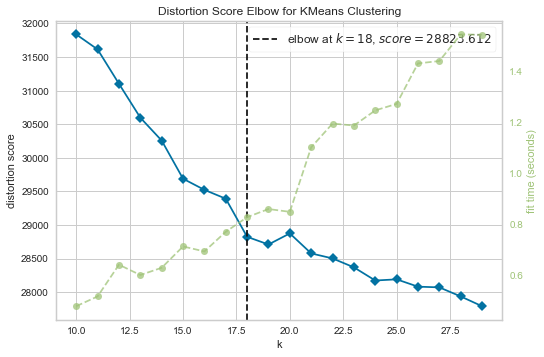

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(10,30))

visualizer.fit(pd.DataFrame(X_train_preprocessed))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [100]:
visualizer.elbow_value_

18

In [101]:
n_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters = n_clusters)
labels = kmeans.fit_predict(X_train_preprocessed)

#### Saving Kmeans model

In [102]:
import pickle

In [106]:
filename = 'kmeans.sav'
pickle.dump(kmeans, open(filename, 'wb'))

#### Loading Kmeans model

In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = n_clusters)

In [113]:
import pickle

filename = 'kmeans.sav'
kmeans = pickle.load(open("../models/" + filename, 'rb'))

**Predicting new users clusters**

In [110]:
labels = kmeans.predict(X_train_preprocessed)
labels_new = kmeans.predict(X_test_preprocessed)

#### Merging clusters to the data set

In [114]:
cluster_users = X_train_preprocessed.copy(deep = True).reset_index()
cluster_users["cluster"] = labels
cluster_users

user_id         0         1         2         3         4         5  \
0           0  0.641947  0.538734  0.331572  0.575235  0.378760  0.030589   
1           1  0.510886  0.355444  0.460066  0.215618  0.394662  0.019866   
2           2  0.585320  0.370867  0.516595  0.405832  0.349865 -0.020155   
3           3  0.458067  0.516310  0.490582  0.619684  0.440850  0.021253   
4           4  0.763097  0.636170  0.287459  0.396669  0.266334  0.035265   
...       ...       ...       ...       ...       ...       ...       ...   
7996     7996  0.446870  0.472117  0.565806  0.367065  0.541950  0.003413   
7997     7997  0.349881  0.615317  0.531556  0.334872  0.476020  0.022322   
7998     7998  0.706682  0.433511  0.423073  0.477784  0.365115 -0.021472   
7999     7999  0.568738  0.409286  0.395868  0.439525  0.286155  0.030045   
8000     8000  0.661291  0.356975  0.407310  0.498461  0.324720  0.024087   

             6         7         8         9        10        11        12  \
0    -0.004011  0.003561  0.018330 -0.002329 -0.020972 -0.015917  0.000612   
1     0.021246  0.038501  0.017261  0.024043  0.033561  0.013485  0.028134   
2     0.016348  0.007899 -0.023184 -0.007581  0.024429  0.013449  0.036723   
3    -0.000856  0.003763 -0.008608 -0.002394  0.023851 -0.005259 -0.012330   
4    -0.001353 -0.002058 -0.023060 -0.028028  0.000562  0.017081  0.008150   
...        ...       ...       ...       ...       ...       ...       ...   
7996 -0.019133  0.016140  0.020892  0.012486  0.025411 -0.026566 -0.006591   
7997 -0.004818  0.002142 -0.046121 -0.029309  0.017650  0.027897 -0.042803   
7998  0.016149 -0.015754 -0.042384 -0.019866  0.010316 -0.001290  0.031297   
7999  0.007173  0.011672 -0.041533 -0.039015  0.008694  0.030064 -0.010983   
8000 -0.010387  0.021786  0.030840  0.010134  0.006453 -0.019014  0.022093   

            13        14        15        16        17        18        19  \
0     0.020415  0.003035  0.013864 -0.004510  0.018796 -0.006211 -0.021421   
1     0.004636 -0.016633 -0.032854  0.034707 -0.006912 -0.028037  0.017749   
2    -0.000608 -0.004631 -0.011143  0.012915 -0.061598 -0.018672  0.006318   
3     0.020147 -0.006313 -0.016869  0.017752 -0.001590  0.004495  0.006094   
4     0.029335  0.014314  0.033593  0.008572 -0.005012  0.021051 -0.000196   
...        ...       ...       ...       ...       ...       ...       ...   
7996 -0.018426 -0.037398 -0.019467  0.013746 -0.021470  0.002404  0.043844   
7997 -0.037767  0.001033 -0.001372  0.062640  0.001099  0.037078  0.019729   
7998 -0.000114  0.020327 -0.016639  0.010173 -0.042423 -0.007305 -0.019918   
7999  0.009752  0.010242  0.031494  0.011336 -0.007889  0.015448 -0.014546   
8000  0.046086 -0.017427 -0.002409 -0.010496  0.021298 -0.011872 -0.001332   

      Birth_year_0  Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  \
0                0             1             0             0             0   
1                0             0             0             0             0   
2                1             0             0             0             0   
3                0             0             0             0             1   
4                1             0             0             0             0   
...            ...           ...           ...           ...           ...   
7996             0             0             0             0             0   
7997             0             0             0             0             1   
7998             0             0             0             0             0   
7999             0             0             0             0             0   
8000             0             1             0             0             0   

      Birth_year_5  Birth_year_6  Birth_year_7  Birth_year_8  Gender_0  \
0                0             0             0             0         1   
1                0             0             1             0         0   
2                0             0             0  

**Doing the same for the new users:**

In [115]:
cluster_new_users = X_test_preprocessed.copy(deep = True).reset_index()
cluster_new_users["cluster"] = labels_new
cluster_new_users

user_id         0         1         2         3         4             5  \
0        8001  0.311501  0.400895  0.663631  0.542730  0.600008  5.178772e-12   
1        8002  0.741870  0.207159  0.836159  0.545866  0.572306  1.433755e-11   
2        8003  0.323517  0.439080  0.413970  0.239310  0.605594  6.428070e-11   
3        8004  0.577820  0.290328  0.355325  0.356443  0.370675  1.183694e-10   
4        8005  0.587223  0.555435  0.692190  0.585880  0.643602 -6.094462e-11   
...       ...       ...       ...       ...       ...       ...           ...   
1995     9996  0.533535  0.688969  0.190225  0.541375  0.609142  2.876160e-11   
1996     9997  0.548272  0.730826  0.190425  0.221016  0.526932 -1.430029e-10   
1997     9998  0.278304  0.372537  0.242745  0.815433  0.343685 -1.313471e-10   
1998     9999  0.316754  0.432810  0.527267  0.411238  0.732452  3.885306e-11   
1999    10000  0.350405  0.634176  0.532963  0.374649  0.585050 -7.999730e-11   

                 6             7             8             9            10  \
0    -4.303747e-11  1.649489e-11  1.483677e-11  1.066010e-10 -1.124384e-10   
1    -4.604887e-11  2.708171e-11  1.449447e-10  8.901584e-11  3.348919e-12   
2     2.146386e-11 -6.230392e-11 -1.996290e-11  6.530552e-11 -4.259069e-11   
3    -5.536163e-12 -6.651148e-11 -1.551235e-10  1.370655e-10  1.544140e-11   
4     7.127024e-13  7.548456e-11  6.763000e-11 -6.769201e-11 -9.399972e-13   
...            ...           ...           ...           ...           ...   
1995  1.575394e-11 -4.049814e-11  5.688371e-12  4.955296e-11 -7.992874e-11   
1996  5.131678e-11 -5.464266e-11  7.099055e-11 -7.685630e-11 -3.154977e-11   
1997 -3.190847e-11 -3.920480e-11 -1.000580e-10 -1.815044e-11  5.575455e-11   
1998 -4.455186e-11 -1.588054e-12 -1.348870e-11 -2.948122e-11 -3.235461e-11   
1999 -1.356766e-10  3.309907e-11 -1.493288e-10  1.503757e-10 -1.881580e-10   

                11            12            13            14            15  \
0    -3.294410e-11  5.622442e-11  1.545007e-10  1.121578e-10  2.048160e-10   
1    -8.549305e-11  1.430951e-10 -4.675199e-12 -1.453133e-10 -7.749976e-11   
2    -1.466703e-10 -2.790861e-12 -1.554261e-10  2.686485e-10 -1.428344e-11   
3    -1.262818e-10  9.830060e-11 -1.328317e-10 -2.336114e-11 -1.124834e-11   
4    -2.336847e-11  9.503139e-11  5.945426e-11 -4.779809e-11  1.080583e-10   
...            ...           ...           ...           ...           ...   
1995  8.496939e-11 -1.158948e-10  1.111962e-10  6.973849e-11  2.252517e-10   
1996  7.533998e-11  5.900021e-11 -1.163909e-10  1.026643e-10  3.117992e-11   
1997  1.203302e-10  2.244129e-10 -7.120724e-11 -6.777508e-11 -6.579300e-12   
1998  1.525690e-11 -5.070250e-11 -1.423773e-10 -5.719127e-11  1.274163e-10   
1999  3.254269e-11  7.856012e-11 -2.812616e-11  7.828492e-12 -3.741842e-11   

                16            17            18            19  Birth_year_0  \
0    -3.434416e-12 -6.263973e-11  8.916953e-11  4.407479e-11             1   
1    -7.589337e-11 -3.002956e-11 -6.980993e-11 -9.851620e-11             0   
2    -4.953316e-11 -5.821416e-11  6.757563e-11 -2.198359e-13             0   
3     2.199250e-11  1.784848e-11  1.133571e-10  2.537526e-11             0   
4    -3.411231e-11 -3.320987e-11  4.586845e-11 -1.605547e-10             1   
...            ...           ...           ...           ...           ...   
1995 -6.646891e-11 -7.425473e-12 -4.948195e-11  6.426978e-11             0   
1996  7.205030e-14  1.115211e-10 -9.683331e-11  1.177118e-10             0   
1997  3.506739e-11 -4.416163e-12  1.161652e-11  9.621336e-11             0   
1998 -7.402398e-11 -4.867198e-11  3.338495e-11  5.912758e-11             0   
1999 -1.300951e-10  2.720647e-11  1.298132e-10  5.271651e-11             0   

      Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  Birth_year_5  \
0                0             0             0             0             0   
1                0             0             0             0      

#### Getting the cluster for each user

This is just a function to retrieve the cluster where a particular user is inserted. We can check, for example, the cluster for Carolina (user_id = 10000). But before, as I am part of the **new_users**, we need to append the information about these new users to the clusters_users dataframe.

In [116]:
all_cluster_users = cluster_users.append(cluster_new_users)
all_cluster_users.reset_index(drop = True, inplace = True)
# all_cluster_users.to_csv("clustered_users.csv")
all_cluster_users

user_id         0         1         2         3         4  \
0            0  0.641947  0.538734  0.331572  0.575235  0.378760   
1            1  0.510886  0.355444  0.460066  0.215618  0.394662   
2            2  0.585320  0.370867  0.516595  0.405832  0.349865   
3            3  0.458067  0.516310  0.490582  0.619684  0.440850   
4            4  0.763097  0.636170  0.287459  0.396669  0.266334   
...        ...       ...       ...       ...       ...       ...   
9996      9996  0.533535  0.688969  0.190225  0.541375  0.609142   
9997      9997  0.548272  0.730826  0.190425  0.221016  0.526932   
9998      9998  0.278304  0.372537  0.242745  0.815433  0.343685   
9999      9999  0.316754  0.432810  0.527267  0.411238  0.732452   
10000    10000  0.350405  0.634176  0.532963  0.374649  0.585050   

                  5             6             7             8             9  \
0      3.058877e-02 -4.010641e-03  3.560682e-03  1.833025e-02 -2.329274e-03   
1      1.986632e-02  2.124560e-02  3.850144e-02  1.726056e-02  2.404276e-02   
2     -2.015500e-02  1.634782e-02  7.898970e-03 -2.318397e-02 -7.581185e-03   
3      2.125257e-02 -8.560863e-04  3.763153e-03 -8.608243e-03 -2.394424e-03   
4      3.526530e-02 -1.353460e-03 -2.058496e-03 -2.305981e-02 -2.802817e-02   
...             ...           ...           ...           ...           ...   
9996   2.876160e-11  1.575394e-11 -4.049814e-11  5.688371e-12  4.955296e-11   
9997  -1.430029e-10  5.131678e-11 -5.464266e-11  7.099055e-11 -7.685630e-11   
9998  -1.313471e-10 -3.190847e-11 -3.920480e-11 -1.000580e-10 -1.815044e-11   
9999   3.885306e-11 -4.455186e-11 -1.588054e-12 -1.348870e-11 -2.948122e-11   
10000 -7.999730e-11 -1.356766e-10  3.309907e-11 -1.493288e-10  1.503757e-10   

                 10            11            12            13            14  \
0     -2.097239e-02 -1.591696e-02  6.115962e-04  2.041481e-02  3.034941e-03   
1      3.356087e-02  1.348493e-02  2.813414e-02  4.635569e-03 -1.663301e-02   
2      2.442919e-02  1.344876e-02  3.672311e-02 -6.083502e-04 -4.630658e-03   
3      2.385135e-02 -5.259465e-03 -1.233019e-02  2.014724e-02 -6.313365e-03   
4      5.616401e-04  1.708118e-02  8.149832e-03  2.933486e-02  1.431448e-02   
...             ...           ...           ...           ...           ...   
9996  -7.992874e-11  8.496939e-11 -1.158948e-10  1.111962e-10  6.973849e-11   
9997  -3.154977e-11  7.533998e-11  5.900021e-11 -1.163909e-10  1.026643e-10   
9998   5.575455e-11  1.203302e-10  2.244129e-10 -7.120724e-11 -6.777508e-11   
9999  -3.235461e-11  1.525690e-11 -5.070250e-11 -1.423773e-10 -5.719127e-11   
10000 -1.881580e-10  3.254269e-11  7.856012e-11 -2.812616e-11  7.828492e-12   

                 15            16            17            18            19  \
0      1.386380e-02 -4.509796e-03  1.879617e-02 -6.210615e-03 -2.142097e-02   
1     -3.285418e-02  3.470659e-02 -6.912334e-03 -2.803692e-02  1.774906e-02   
2     -1.114252e-02  1.291493e-02 -6.159797e-02 -1.867198e-02  6.317742e-03   
3     -1.686948e-02  1.775216e-02 -1.590438e-03  4.495123e-03  6.093658e-03   
4      3.359349e-02  8.571605e-03 -5.012278e-03  2.105117e-02 -1.962484e-04   
...             ...           ...           ...           ...           ...   
9996   2.252517e-10 -6.646891e-11 -7.425473e-12 -4.948195e-11  6.426978e-11   
9997   3.117992e-11  7.205030e-14  1.115211e-10 -9.683331e-11  1.177118e-10   
9998  -6.579300e-12  3.506739e-11 -4.416163e-12  1.161652e-11  9.621336e-11   
9999   1.274163e-10 -7.402398e-11 -4.867198e-11  3.338495e-11  5.912758e-11   
10000 -3.741842e-11 -1.300951e-10  2.720647e-11  1.298132e-10  5.271651e-11   

       Birth_year_0  Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  \
0                 0             1             0             0             0   
1                 0             0             0             0             0   
2                 1             0             0             0             0   
3                 0        

In [117]:
@interact
def get_cluster(column = "cluster", user_id = (0, len(all_cluster_users)-1, 1)):
    return pd.DataFrame(all_cluster_users.loc[all_cluster_users["user_id"] == user_id, column])

interactive(children=(Text(value='cluster', description='column'), IntSlider(value=5000, description='user_id'…

#### Getting the centroids for each cluster:

From now on we will be using only the `cluster_users` dataframe (the one with the users used for training). In this case, the new users are only relevant to check the results.

By getting the centroids of a cluster, we can check the average characteristics of it. Let's start by getting the centroids for every cluster:

In [118]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns = cluster_users.columns.drop(["user_id", "cluster"]))
cluster_centroids["cluster"] = range(kmeans.n_clusters)
cluster_centroids.to_csv("clusters_centroids.csv")
cluster_centroids.head()

0         1         2         3         4         5         6  \
0  0.558941  0.492330  0.460207  0.414192  0.417661  0.001428  0.001040   
1  0.553680  0.493262  0.441041  0.453899  0.420019 -0.000420 -0.002007   
2  0.547266  0.495972  0.455475  0.427719  0.413765  0.000084  0.000926   
3  0.564401  0.482612  0.455849  0.455639  0.408375 -0.001290  0.000875   
4  0.547613  0.496040  0.442871  0.443413  0.418454  0.001190 -0.003727   

          7         8         9        10        11        12        13  \
0  0.001035 -0.000560  0.000353  0.000627 -0.000083 -0.000280 -0.000628   
1 -0.001274 -0.000902  0.000138 -0.001772 -0.002010 -0.000196  0.001176   
2 -0.000334 -0.000744  0.001808  0.001761 -0.000052  0.000030 -0.001049   
3  0.000856 -0.002446  0.000449 -0.000333 -0.003323  0.002221  0.002157   
4 -0.001664 -0.005879  0.001325 -0.001512 -0.001231 -0.001097 -0.000270   

         14        15        16        17        18        19  Birth_year_0  \
0 -0.002746 -0.002292  0.002720 -0.002397 -0.000907  0.002704      0.135283   
1 -0.000675 -0.001379 -0.001588  0.001585 -0.001275 -0.002081      0.182994   
2 -0.000551 -0.000640  0.001769 -0.002447 -0.001271  0.001474      0.153704   
3 -0.000403 -0.002186 -0.000020 -0.002146 -0.004964 -0.002472      0.187500   
4  0.000122  0.000261 -0.001512  0.002135  0.002971  0.001877      0.174757   

   Birth_year_1  Birth_year_2  Birth_year_3  Birth_year_4  Birth_year_5  \
0      0.175503      0.171846      0.053016      0.087751      0.076782   
1      0.168207      0.133087      0.090573      0.079482      0.085028   
2      0.177778      0.172222      0.087037      0.100000      0.079630   
3      0.145833      0.177083      0.062500      0.135417      0.062500   
4      0.194175      0.184466      0.029126      0.106796      0.077670   

   Birth_year_6  Birth_year_7  Birth_year_8      Gender_0      Gender_1  \
0      0.100548      0.076782      0.122486  2.682209e-07  8.226689e-01   
1      0.073937      0.096118      0.090573  8.059152e-01 -1.788139e-07   
2      0.074074      0.075926      0.079630  2.682209e-07  8.111109e-01   
3      0.052083      0.093750      0.083333  8.437500e-01  2.980232e-08   
4      0.087379      0.097087      0.048544 -5.960464e-08  8.940697e-08   

   Gender_2  Civil_status_0  Civil_status_1  Civil_status_2  Civil_status_3  \
0  0.177331    9.999997e-01   -2.980232e-08    1.043081e-07    1.490116e-07   
1  0.194085   -8.940697e-08   -5.960464e-08    1.000000e+00    1.490116e-07   
2  0.188889   -8.940697e-08   -5.960464e-08    1.043081e-07    9.999996e-01   
3  0.156250    1.490116e-08    1.000000e+00    0.000000e+00   -2.980232e-08   
4  1.000000    4.470348e-08   -2.980232e-08    2.980232e-08    9.999999e-01   

   Degree_0  Degree_1  Degree_2  Degree_3  Degree_4  Degree_5  Degree_6  \
0  0.133455  0.149909  0.148080  0.173675  0.146252  0.122486  0.126143   
1  0.149723  0.164510  0.136784  0.147874  0.138632  0.142329  0.120148   
2  0.150000  0.161111  0.135185  0.153704  0.144444  0.138889  0.116667   
3  0.052083  0.145833  0.239583  0.145833  0.114583  0.187500  0.114583   
4  0.126214  0.184466  0.126214  0.174757  0.165049  0.126214  0.097087   

   Professional_status_0  Professional_status_1  Professional_status_2  \
0               0.166362               0.162706               0.115174   
1               0.134935               0.131238               0.129390   
2               0.142593               0.177778               0.111111   
3               0.260417               0.166667               0.125000   
4               0.155340               0.067961               0.194175   

   Professional_status_3  Professional_status_4  Professional_status_5  \
0               0.124314               0.140768               0.148080   
1               0.177449               0.146026               0.123845   
2               0.137037               0.131481               0.125926   
3               0.083333               0.125000               0.

**Example:** Let's check the centroids for the cluster where the user_id = 10000 (Carolina) is inserted:

**Consider the following profile for Emila:**

- **Birth_year_6** (born between 1991 and 2000)
- **Gender_1** (female)
- **Civil_status_2** (single)
- **Degree_5** (master degree)
- **Professional_status_1** (student)
- **Annual_income_0** (less than 15)
- **Practice_sports_1** (yes)

In [120]:
@interact

def get_centroids(cluster = (0, kmeans.n_clusters-1, 1)):
    cluster_x_centroids = pd.DataFrame(cluster_centroids.loc[cluster_centroids["cluster"] == cluster]).round(4)
    display(cluster_x_centroids)
    
    for feature in ["Birth_year", "Gender", "Civil_status", "Degree", "Professional_status", "Annual_income", "Practice_sports"]:
        feature_dist = cluster_x_centroids[[col for col in cluster_x_centroids.columns if str(col).startswith(feature)]].T
        print("\033[1m%s:\n" % feature)
        display(feature_dist.sort_values(feature_dist.columns[0], ascending = False)\
                .rename(columns = {feature_dist.columns[0]:"distribution"}))

interactive(children=(IntSlider(value=8, description='cluster', max=17), Output()), _dom_classes=('widget-inte…

We can see that for the clusters in which a particular value is dominant (**Gender**, **Civil status** and **Practice sports**), Emila is inserted in the right place. For the other ones, as the users are quite different from each other, the distributions are similar between the possible values.

#### Features data dictionary (maybe no need for this)

By analysing this cluster, we can see the average distribution for each feature. To better understand what each dummy feature represents, let's take a look at the correspondent labels:

**Birth year**
- Birth_year_0: born between 1900 and 1920
- Birth_year_1: born between 1921 and 1940
- Birth_year_2: born between 1941 and 1960
- Birth_year_3: born between 1961 and 1970
- Birth_year_4: born between 1971 and 1980
- Birth_year_5: born between 1981 and 1990
- Birth_year_6: born between 1991 and 2000
- Birth_year_7: born between 2001 and 2010
- Birth_year_8: born between 2011 and 2021

**Gender**
- Gender_0: male
- Gender_1: female
- Gender_2: non-binary

**Civil status**
- Civil_status_0: divorced
- Civil_status_1: married
- Civil_status_2: single
- Civil_status_3: widow

**Degree**
- Degree_0: other
- Degree_1: high school diploma
- Degree_2: technical degree
- Degree_3: bachelor degree
- Degree_4: major degree
- Degree_5: master degree
- Degree_6: doctor degree

**Professional status**
- Professional_status_0: unemployed
- Professional_status_1: student
- Professional_status_2: retired
- Professional_status_3: freelancer
- Professional_status_4: fixed term contract
- Professional_status_5: permanent contract
- Professional_status_6: business owner

**Annual income (in thousands)**
- Annual_income_0: less than 15
- Annual_income_1: between 15 and 30
- Annual_income_2: between 30 and 45
- Annual_income_3: between 45 and 70
- Annual_income_4: between 70 and 100
- Annual_income_5: more than 100

**Practice sports**
- Practice_sports_0: no
- Practice_sports_1: yes

#### Getting the users, insights and insight categories for each cluster

With this function, we can check the user_ids of all users inside each cluster.

We can then use this to check for the insights liked by each user and try to find out which are the ones that most of them are interested in.

In [123]:
@interact
def get_users_and_insights(column = "user_id", cluster = (0, kmeans.n_clusters-1, 1)):
    #displaying all users (including the ones) but then using the df with only the users that were trained
#     display(pd.DataFrame(all_cluster_users.loc[all_cluster_users["cluster"] == cluster, column]))
    
    cluster_x_users = pd.DataFrame(all_cluster_users.loc[all_cluster_users["cluster"] == cluster, column])
#     print("Number of users for training:", len(cluster_x_users))
    
    liked_insights = final_df[final_df["True"] == 1] #only selecting the insights that the users like from the final_df
    cluster_x_users_likes = pd.merge(cluster_x_users, liked_insights, on = "user_id",
                                     how = "left")[["user_id", "insight_id", "cat_id"]]
    
#     print("\033[1m\n\nINSIGHTS:\n")
    most_liked_insightids = pd.DataFrame(cluster_x_users_likes.groupby("insight_id")["user_id"].count()
    .sort_values(ascending = False)).rename(columns = {"user_id":"n_likes"}).reset_index().head(30)
    most_liked_insights = pd.merge(most_liked_insightids, insight_dic, on = "insight_id", how = "left")
    most_liked_insights_with_catids = pd.merge(most_liked_insights, insight_features_df, on = "insight_id", how = "left")
    most_liked_insights_with_cats = pd.merge(most_liked_insights_with_catids, insight_cat_dic, on = "cat_id", how = "left")
#     display(most_liked_insights)
    
#     print("\033[1m\n\nINSIGHTS CATEGORIES:\n\n")
    
#     print("\033[1mFIRST APPROACH -\033[0m dropping duplicates of user_id and cat_id to get the number of users that like one category, regardless of how many insights from that category the users are interested in:\n")
#     most_liked_catids = pd.DataFrame(cluster_x_users_likes.drop_duplicates(["user_id", "cat_id"])
#     .groupby("cat_id")["user_id"].count().sort_values(ascending = False))\
#     .rename(columns = {"user_id":"n_likes"}).reset_index().head(20)
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
#     display(most_liked_cats)
    
#     print("\033[1m\n\nSECOND APPROACH -\033[0m considering all observations; the most liked categories will be the ones with the most number of insights that the users are interested in:\n")
    most_liked_catids = pd.DataFrame(cluster_x_users_likes.groupby("cat_id")["user_id"].count()
    .sort_values(ascending = False)).rename(columns = {"user_id":"n_likes"}).reset_index()#.head(20)
    most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
    
    insight_per_cat = insight_features_df.groupby("cat_id").count().rename(columns = {"insight_id":"n_insights"})
    most_liked_cats_4real = pd.merge(most_liked_cats, insight_per_cat, on = "cat_id")
    most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["n_likes"] / most_liked_cats_4real["n_insights"]
    most_liked_cats_4real = most_liked_cats_4real.loc[(most_liked_cats_4real["n_insights"] >= 5) & (most_liked_cats_4real["likes_rate"] >= 1)]
#     display(most_liked_cats_4real.sort_values("likes_rate", ascending = False))
    
    
    return pd.DataFrame(all_cluster_users.loc[all_cluster_users["cluster"] == cluster, column]),\
most_liked_insights_with_cats,\
most_liked_cats_4real.sort_values("likes_rate", ascending = False)

interactive(children=(Text(value='user_id', description='column'), IntSlider(value=8, description='cluster', m…

### Final Recommendation System:

Finally, we just need to build the recommendation system to a particular new user. For that, let's get Carolina's data and recommend the categories of the cluster she is inserted, but excluding the ones she already likes.

In [124]:
@interact
def final_cat_recommend(user_id = (0, len(all_cluster_users)-1, 1)):
    user_x_cluster = get_cluster(user_id = user_id)["cluster"].values[0]
    print("CLUSTER %s" % user_x_cluster)
    
    user_x_liked_insights = pd.DataFrame(final_df.loc[((final_df["True"] == 1) | (final_df["False"] == 1)) & (final_df["user_id"] == user_id), "insight_id"])
    user_x_liked_cat_ids = pd.merge(user_x_liked_insights, insight_features_df, on = "insight_id", how = "left")\
    .drop_duplicates(subset = "cat_id")["cat_id"]
    user_x_liked_cats = pd.merge(pd.DataFrame(user_x_liked_cat_ids), insight_cat_dic, on = "cat_id", how = "left")
    user_x_liked_cats_list = list(user_x_liked_cats["category"].values)
    
    a, b, c = get_users_and_insights(cluster = user_x_cluster)
    
    to_recommend = c[[c.iloc[i]["category"] not in user_x_liked_cats_list for i in range(len(c))]]
    
#     for cat in to_recommend.category:
#         print(cat)
    
    return to_recommend

interactive(children=(IntSlider(value=5000, description='user_id', max=10000), Output()), _dom_classes=('widge…

If we want to recommend the particular insights, we can use the following function:

In [125]:
@interact
def final_insights_recommend(user_id = (0, len(all_cluster_users)-1, 1)):
    user_x_cluster = get_cluster(user_id = user_id)["cluster"].values[0]
    print("CLUSTER %s" % user_x_cluster)
    
    user_x_insight_ids = pd.DataFrame(final_df.loc[((final_df["True"] == 1) | (final_df["False"] == 1)) & (final_df["user_id"] == user_id), ["insight_id", "cat_id"]])
    user_x_insight_ids = pd.DataFrame(user_x_insight_ids.drop_duplicates(subset = "insight_id")["insight_id"])
    user_x_insights = pd.merge(user_x_insight_ids, insight_dic, on = "insight_id", how = "left")
    
    user_x_insights_list = list(user_x_insights["insight"].values)
    
    a, b, c = get_users_and_insights(cluster = user_x_cluster)
    
    insights_to_recommend = b[[b.iloc[i]["insight"] not in user_x_insights_list for i in range(len(b))]][["insight", "category"]]
    cats_to_recommend = pd.DataFrame(insights_to_recommend.drop_duplicates(subset = "category")["category"])
    
#     user_x_cats_list = list(user_x_insights["insight"].values)
#     print(user_x_insights)
    
    return insights_to_recommend, cats_to_recommend

interactive(children=(IntSlider(value=5000, description='user_id', max=10000), Output()), _dom_classes=('widge…

Next we can see the recommendations for Emila, for both insights and insight categories:

In [126]:
insights, cats = final_insights_recommend(user_id = 10000)
display(insights)
display(cats)

CLUSTER 8


insight  \
0   Businesses | Vehicle, aircraft and boat | Aviation repair station   
1                                   Other | TypeAhead | Coming of age   
2                   Businesses | Shopping & retail | Rent-to-own shop   
3                     Businesses | Food & drink | Xinjiang restaurant   
4                                         Other | TypeAhead | Holiday   
5                     Non-business places | Outdoor recreation | Pond   
7                                  Other | Brand | Musical instrument   
8                     Businesses | Local service | Personal assistant   
10                                           Businesses | Hotel & B&B   
11                                       Other | Brand | Patio/Garden   
12                       Businesses | Food & drink | Asian restaurant   
13                      Businesses | Shopping & retail | Fishing shop   
14         Businesses | Arts & entertainment | Decorative arts museum   
15       Businesses | Vehicle, aircraft and boat | Marine supply shop   
16                        Businesses | Local service | Animal shelter   
17                    Businesses | Food & drink | Armenian restaurant   
18               Businesses | Food & drink | Uttar Pradesh restaurant   
19                        Businesses | Food & drink | Soba restaurant   
20                      Businesses | Food & drink | Indian restaurant   
21                          Businesses | Travel & transport | Airport   
22                       Businesses | Medical & health | Psychiatrist   
23              Non-business places | City infrastructure | Promenade   
24                    Businesses | Travel & transport | Train station   
25              Businesses | Food & drink | Emilia-Romagna restaurant   
26                Businesses | Food & drink | Shanghainese restaurant   
27            Businesses | Travel & transport | Public transport stop   
28         Businesses | Medical & health | Obstetrician-gynaecologist   
29                       Businesses | Shopping & retail | Pop-up shop   

                   category  
0                  AVIATION  
1                     Other  
2        SHOPPING AND DEALS  
3            FOOD AND DRINK  
4      TRAVEL AND VACATIONS  
5       Non-business places  
7                     MUSIC  
8      PERSONAL IMPROVEMENT  
10  HOSPITALITY AND TOURISM  
11                GARDENING  
12           FOOD AND DRINK  
13       SHOPPING AND DEALS  
14                   DESIGN  
15           MOTOR VEHICLES  
16         PETS AND ANIMALS  
17           FOOD AND DRINK  
18           FOOD AND DRINK  
19           FOOD AND DRINK  
20           FOOD AND DRINK  
21                   TRAVEL  
22       HEALTH AND FITNESS  
23      Non-business places  
24                   TRAVEL  
25           FOOD AND DRINK  
26           FOOD AND DRINK  
27                   TRAVEL  
28       HEALTH AND FITNESS  
29       SHOPPING AND DEALS

category
0                  AVIATION
1                     Other
2        SHOPPING AND DEALS
3            FOOD AND DRINK
4      TRAVEL AND VACATIONS
5       Non-business places
7                     MUSIC
8      PERSONAL IMPROVEMENT
10  HOSPITALITY AND TOURISM
11                GARDENING
14                   DESIGN
15           MOTOR VEHICLES
16         PETS AND ANIMALS
21                   TRAVEL
22       HEALTH AND FITNESS

### Visualization of clusters - UMAP

In this section, we will present the visual results of the cluster users representation. For that, we need to reduce the dimension to 2 and after we have tried several techniques, we chose to proceed with **UMAP**.

#### Initial visualization

In [127]:
import umap

In [128]:
reducer = umap.UMAP()
data = all_cluster_users.drop(["user_id", "cluster"], axis = 1)

embedding = reducer.fit_transform(data)

In [129]:
all_labels = list(labels) + list(labels_new)
len(all_labels)

10001

In [130]:
df_umap = pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1], label=all_labels))
groups_umap = df_umap.groupby('label')
df_umap

x         y  label
0       9.467255  3.197191      3
1      10.225479  6.363630     12
2       0.733148  2.701592      1
3       9.681233  6.854997     12
4       8.325698  2.080371     11
...          ...       ...    ...
9996    2.049377  6.234874      9
9997   -0.020288  4.519548      7
9998    5.993085  3.463393     13
9999    0.189008  4.290342      7
10000   7.995570  5.969640      8

[10001 rows x 3 columns]

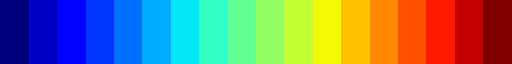

In [131]:
from matplotlib import cm
cm.get_cmap('jet', len(groups_umap))

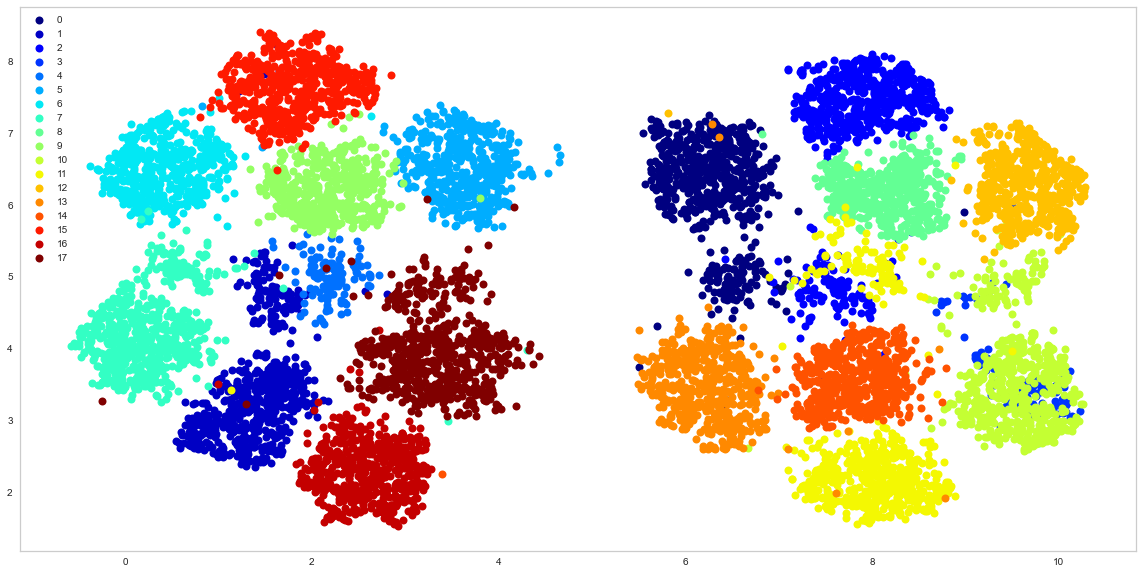

In [132]:
# Plot
fig, ax = plt.subplots(figsize=(20,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, groups in groups_umap:
#     r, g, b = random.random(), random.random(), random.random()
    ax.plot(groups.x, groups.y, marker='o', linestyle='', ms=8, label=name, color = cm.get_cmap('jet', len(groups_umap))(name))
ax.legend()
plt.grid(False)
plt.show()

### Showing distribution by user profile features:

In [143]:
labeled_user_profiles = pd.read_csv("../data/processed/profile_data.csv").drop("Unnamed: 0", axis = 1)
Emila_data = pd.read_csv("../data/external/Emilas_profile.csv").drop("Unnamed: 0", axis = 1)

In [144]:
all_labeled_user_profiles = labeled_user_profiles.append(Emila_data).reset_index()
all_labeled_user_profiles

index  user_id  Birth year  Gender Civil status  Degree  \
0          0        0        1937    male      married       3   
1          1        1        2007  female      married       5   
2          2        2        1912    male       single       3   
3          3        3        1972  female      married       4   
4          4        4        1909    male       single       5   
...      ...      ...         ...     ...          ...     ...   
9996    9996     9996        1946  female        widow       1   
9997    9997     9997        1970    male      married       3   
9998    9998     9998        2004    male     divorced       5   
9999    9999     9999        1929    male      married       4   
10000      0    10000        1998  female       single       3   

       Professional status  Annual income Practice sports  
0                        6          10000             yes  
1                        1             30             yes  
2                        6          10000              no  
3                        4             45             yes  
4                        1            100             yes  
...                    ...            ...             ...  
9996                     1             45              no  
9997                     1             30              no  
9998                     2            100             yes  
9999                     6             45              no  
10000                    1             15             yes  

[10001 rows x 9 columns]

In [145]:
# imputer to fill null values with the most frequent value
imputer = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')

Let's take the labeled user profiles df and make only some of the transformations on the data that were done before (essencially creating bins), but letting the labeled values instead of encoding them:

#### Creating the Pipeline:

In [146]:
def rename(data):
    data = data.rename(columns = {"Birth year":"Birth_year",
                                  "Civil status":"Civil_status",
                                  "Professional status":"Professional_status",
                                  "Annual income":"Annual_income",
                                  "Practice sports":"Practice_sports"})
    return data

#Create a pipeline with this step
rename_columns = Pipeline([
    ("rename", DataframeFunctionTransformer(rename))
])

In [147]:
labeled_user_profiles

user_id  Birth year  Gender Civil status  Degree  Professional status  \
0           0        1937    male      married       3                    6   
1           1        2007  female      married       5                    1   
2           2        1912    male       single       3                    6   
3           3        1972  female      married       4                    4   
4           4        1909    male       single       5                    1   
...       ...         ...     ...          ...     ...                  ...   
9995     9995        1931  female       single       3                    2   
9996     9996        1946  female        widow       1                    1   
9997     9997        1970    male      married       3                    1   
9998     9998        2004    male     divorced       5                    2   
9999     9999        1929    male      married       4                    6   

      Annual income Practice sports  
0             10000             yes  
1                30             yes  
2             10000              no  
3                45             yes  
4               100             yes  
...             ...             ...  
9995          10000              no  
9996             45              no  
9997             30              no  
9998            100             yes  
9999             45              no  

[10000 rows x 8 columns]

In [148]:
def birth_year(data): 
#     data = data.dropna(subset=['Birth year'], how="any")
    data["Birth_year"] = data["Birth_year"].astype(int)
    birth_year_cat = pd.cut(data["Birth_year"], bins = [1899,1920,1940,1960,1970,1980,1990,2000,2010,2021],
                            labels=["1900 - 1920", "1921 - 1940", "1941 - 1960", "1961 - 1970", "1971 - 1980",
                                    "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2021"])
    data['Birth_year'] = birth_year_cat
    return data

#Create a pipeline with this step
birth_year_cat = Pipeline([
    ("birth_year", DataframeFunctionTransformer(birth_year))
])

In [149]:
def degree(data):
    data["Degree"] = np.where(data["Degree"] == 0, "Other",
                     np.where(data["Degree"] == 1, "High School Diploma",
                     np.where(data["Degree"] == 2, "Technical Degree",
                     np.where(data["Degree"] == 3, "Bachelor Degree",
                     np.where(data["Degree"] == 4, "Major Degree",
                     np.where(data["Degree"] == 5, "Master Degree",
                     np.where(data["Degree"] == 6, "Doctor Degree", data["Degree"])))))))
#     data["Degree"].fillna(0, inplace = True)  
    return data

#Create a pipeline with this step
degree_cat = Pipeline([
    ("degree", DataframeFunctionTransformer(degree))
])

In [150]:
def professional_status(data):
    data["Professional_status"] = np.where(data["Professional_status"] == 0, "Unemployed",
                                  np.where(data["Professional_status"] == 1, "Student",
                                  np.where(data["Professional_status"] == 2, "Retired",      
                                  np.where(data["Professional_status"] == 3, "Freelancer",
                                  np.where(data["Professional_status"] == 4, "Fixed term contract",
                                  np.where(data["Professional_status"] == 5, "Permanent contact",
                                  np.where(data["Professional_status"] == 6, "Business owner", data["Professional_status"])))))))
#     data["Professional status"].fillna(0, inplace = True)  
    return data

#Create a pipeline with this step
professional_status_cat = Pipeline([
    ("professional_status", DataframeFunctionTransformer(professional_status))
])

For the annual income, these values represent the **upper limit** in thousands, that is, a value of 15 means "less than 15.000€"

In [151]:
def annual_income(data):
    data["Annual_income"] = data["Annual_income"].astype(int)
    data["Annual_income"] = np.where(data["Annual_income"] == 15, "Less than 15.000€",
                            np.where(data["Annual_income"] == 30, "Between 15.000€ and 30.000€",
                            np.where(data["Annual_income"] == 45, "Between 30.000€ and 45.000€",
                            np.where(data["Annual_income"] == 70, "Between 45.000€ and 70.000€",
                            np.where(data["Annual_income"] == 100, "Between 70.000€ and 100.000€",
                            np.where(data["Annual_income"] == 10000, "More than 100.000€", data["Annual_income"]))))))
#     data["Annual income"].fillna(0, inplace = True)
    return data

#Create a pipeline with this step
annual_income_cat = Pipeline([
    ("annual_income", DataframeFunctionTransformer(annual_income))
])

In [152]:
def fill_na(data):
    data[data.columns.to_list()] = pd.DataFrame(imputer.fit_transform(data[data.columns.to_list()]))
#     data.dropna(inplace = True)
    
    return data

final_fill_na = Pipeline([
    ("fill_na", DataframeFunctionTransformer(fill_na))
])

**Final Pipeline:**

In [153]:
preprocessing = Pipeline([("rename", rename_columns),
                          ("birth_year", birth_year_cat),
                          ("degree", degree_cat),
                          ("professional_status", professional_status_cat),
                          ("annual_income", annual_income_cat),
                          ("fill_na", final_fill_na)
                         ])

Now let's use this to create the `real_labeled_user_profile`:

#### Final labeled data:

In [154]:
real_labeled_user_profile = preprocessing.fit_transform(all_labeled_user_profiles)
real_labeled_user_profile

index user_id   Birth_year  Gender Civil_status               Degree  \
0         0       0  1921 - 1940    male      married      Bachelor Degree   
1         1       1  2001 - 2010  female      married        Master Degree   
2         2       2  1900 - 1920    male       single      Bachelor Degree   
3         3       3  1971 - 1980  female      married         Major Degree   
4         4       4  1900 - 1920    male       single        Master Degree   
...     ...     ...          ...     ...          ...                  ...   
9996   9996    9996  1941 - 1960  female        widow  High School Diploma   
9997   9997    9997  1961 - 1970    male      married      Bachelor Degree   
9998   9998    9998  2001 - 2010    male     divorced        Master Degree   
9999   9999    9999  1921 - 1940    male      married         Major Degree   
10000     0   10000  1991 - 2000  female       single      Bachelor Degree   

       Professional_status                 Annual_income Practice_sports  
0           Business owner            More than 100.000€             yes  
1                  Student   Between 15.000€ and 30.000€             yes  
2           Business owner            More than 100.000€              no  
3      Fixed term contract   Between 30.000€ and 45.000€             yes  
4                  Student  Between 70.000€ and 100.000€             yes  
...                    ...                           ...             ...  
9996               Student   Between 30.000€ and 45.000€              no  
9997               Student   Between 15.000€ and 30.000€              no  
9998               Retired  Between 70.000€ and 100.000€             yes  
9999        Business owner   Between 30.000€ and 45.000€              no  
10000              Student             Less than 15.000€             yes  

[10001 rows x 9 columns]

#### Distribution by Birth_year

In [155]:
users_year = list(real_labeled_user_profile["Birth_year"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 1, 2, ..., 1, 0, 8], dtype=int64),
 array(['1921 - 1940', '2001 - 2010', '1900 - 1920', '1971 - 1980',
        '1961 - 1970', '1941 - 1960', '1981 - 1990', '2011 - 2021',
        '1991 - 2000'], dtype=object))

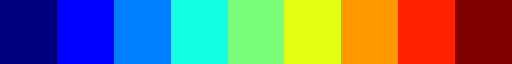

In [156]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

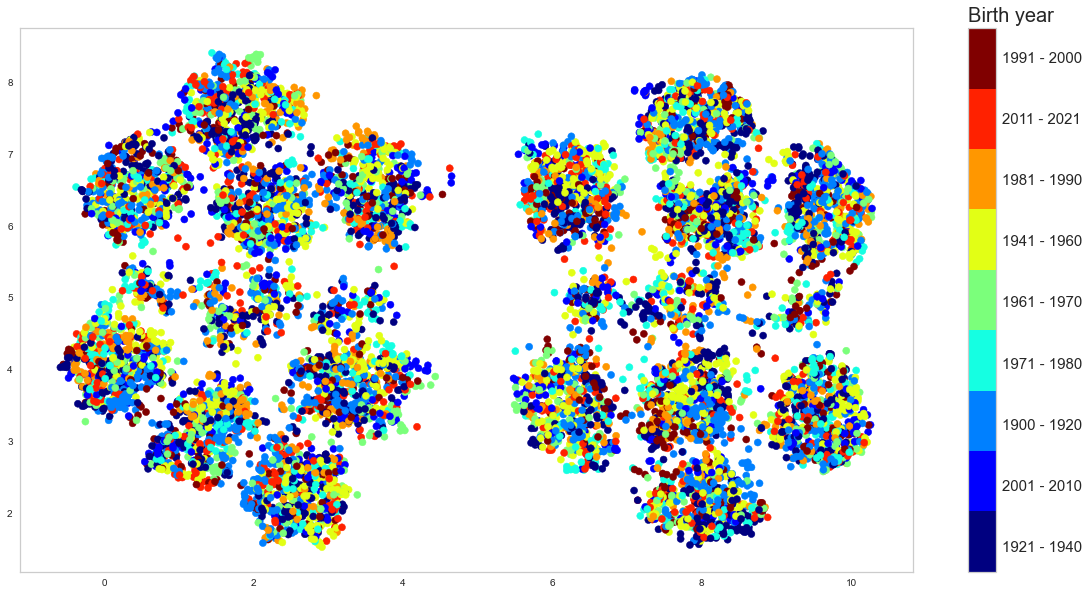

In [157]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(10, 0.35 + 0.9 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Birth year', loc = 'left', fontsize = 20)
plt.grid(False)
plt.show()

#### Distribution by Gender

In [158]:
users_gender = list(real_labeled_user_profile.Gender.values)

ints, gen = pd.factorize(users_gender)
ints, gen

(array([0, 1, 0, ..., 0, 0, 1], dtype=int64),
 array(['male', 'female', 'non_binary'], dtype=object))

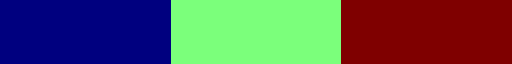

In [159]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

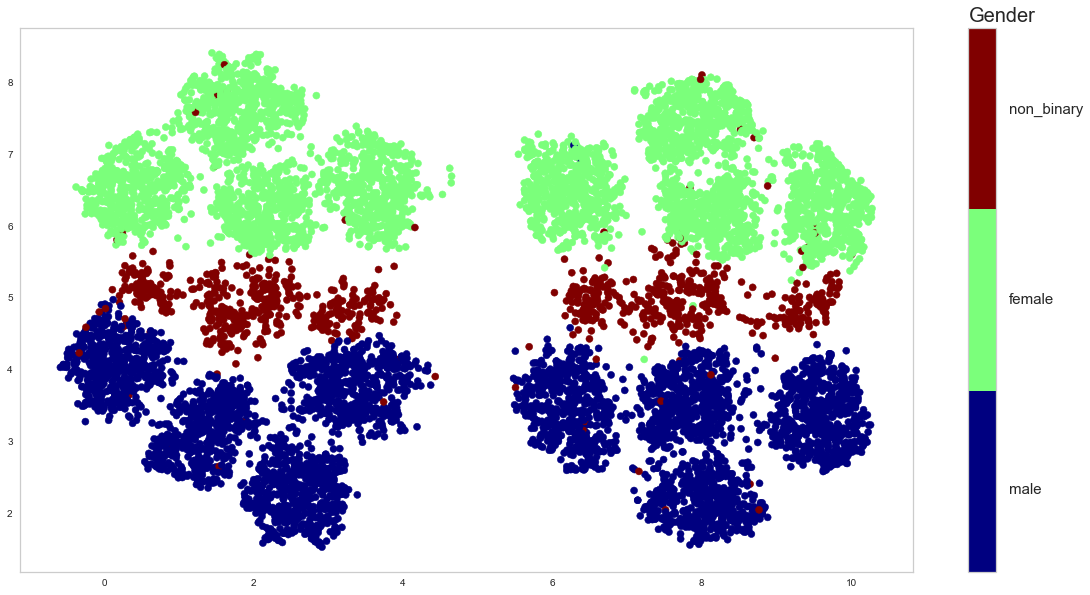

In [160]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(3, 0.3 + 0.7 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Gender', loc = 'left', fontsize = 20)
plt.grid(False)
plt.show()

#### Distribution by Civil status

In [161]:
users_year = list(real_labeled_user_profile["Civil_status"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 0, 1, ..., 2, 0, 1], dtype=int64),
 array(['married', 'single', 'divorced', 'widow'], dtype=object))

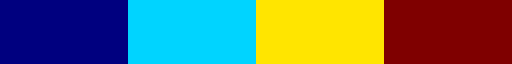

In [162]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

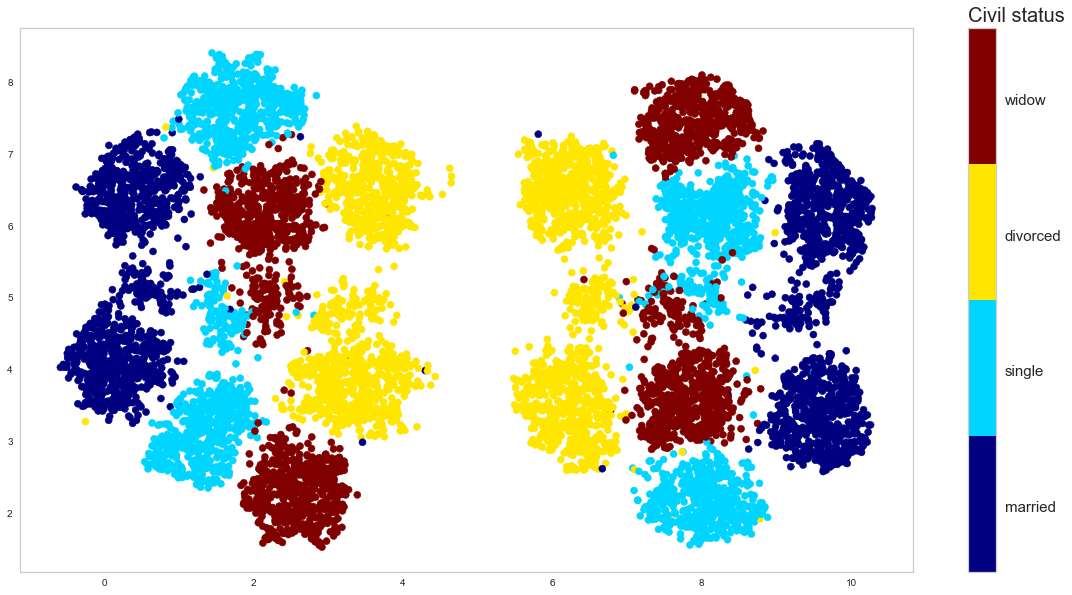

In [163]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(4, 0.35 + 0.75 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Civil status', loc = 'left', fontsize = 20)
plt.grid(False)
plt.show()

#### Distribution by Degree

In [164]:
users_year = list(real_labeled_user_profile["Degree"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 1, 0, ..., 1, 2, 0], dtype=int64),
 array(['Bachelor Degree', 'Master Degree', 'Major Degree',
        'High School Diploma', 'Doctor Degree', 'Other',
        'Technical Degree'], dtype=object))

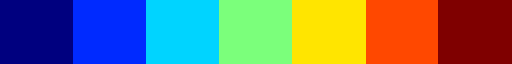

In [165]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

Text(0.0, 1.0, 'Degree')

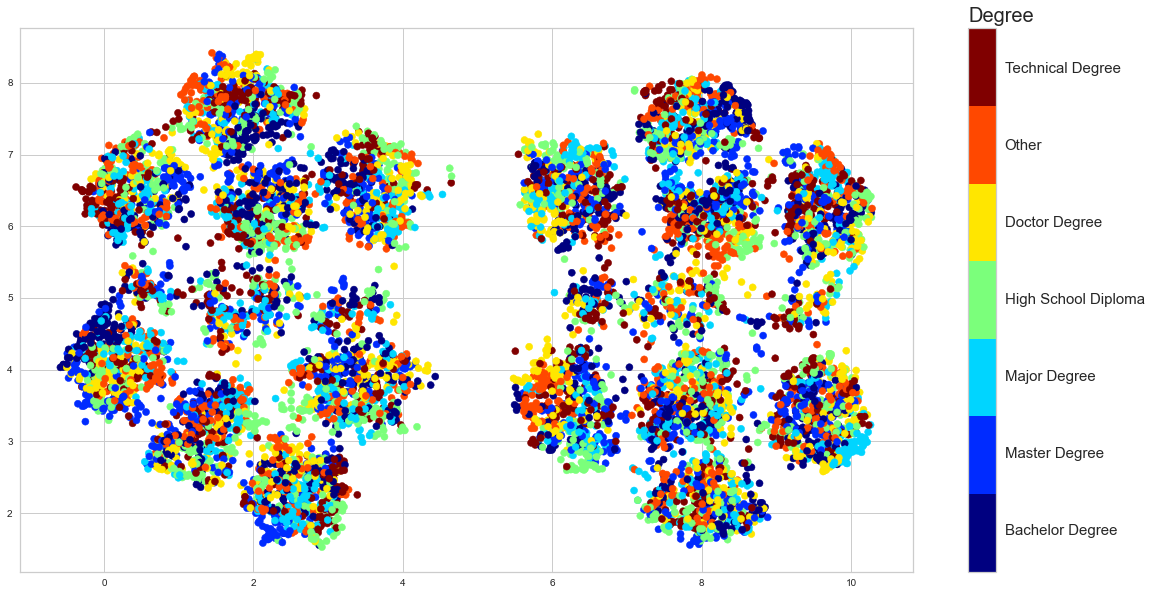

In [166]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(8, 0.45 + 0.85 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Degree', loc = 'left', fontsize = 20)

#### Distribution by Professional status

In [167]:
users_year = list(real_labeled_user_profile["Professional_status"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 1, 0, ..., 3, 0, 1], dtype=int64),
 array(['Business owner', 'Student', 'Fixed term contract', 'Retired',
        'Permanent contact', 'Unemployed', 'Freelancer'], dtype=object))

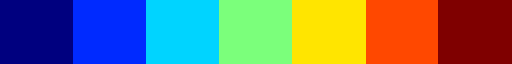

In [168]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

Text(0.0, 1.0, 'Professional status')

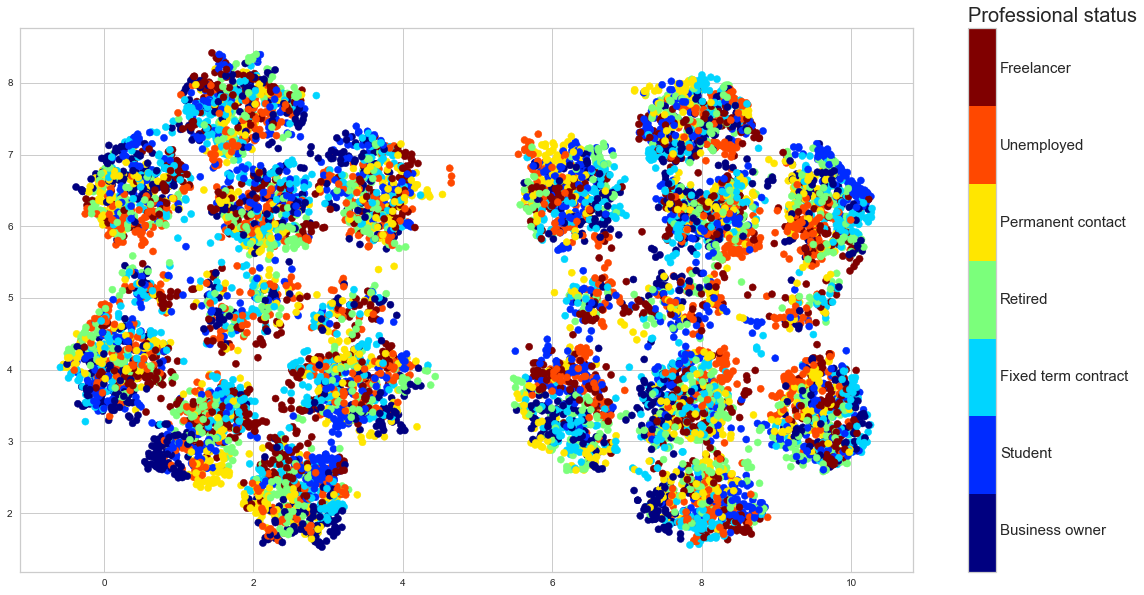

In [169]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(7, 0.45 + 0.85 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Professional status', loc = 'left', fontsize = 20)

#### Distribution by Annual income

In [170]:
users_year = list(real_labeled_user_profile["Annual_income"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 1, 0, ..., 3, 2, 5], dtype=int64),
 array(['More than 100.000€', 'Between 15.000€ and 30.000€',
        'Between 30.000€ and 45.000€', 'Between 70.000€ and 100.000€',
        'Between 45.000€ and 70.000€', 'Less than 15.000€'], dtype=object))

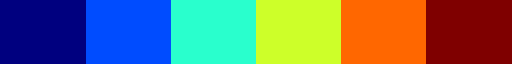

In [171]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

Text(0.0, 1.0, 'Annual income')

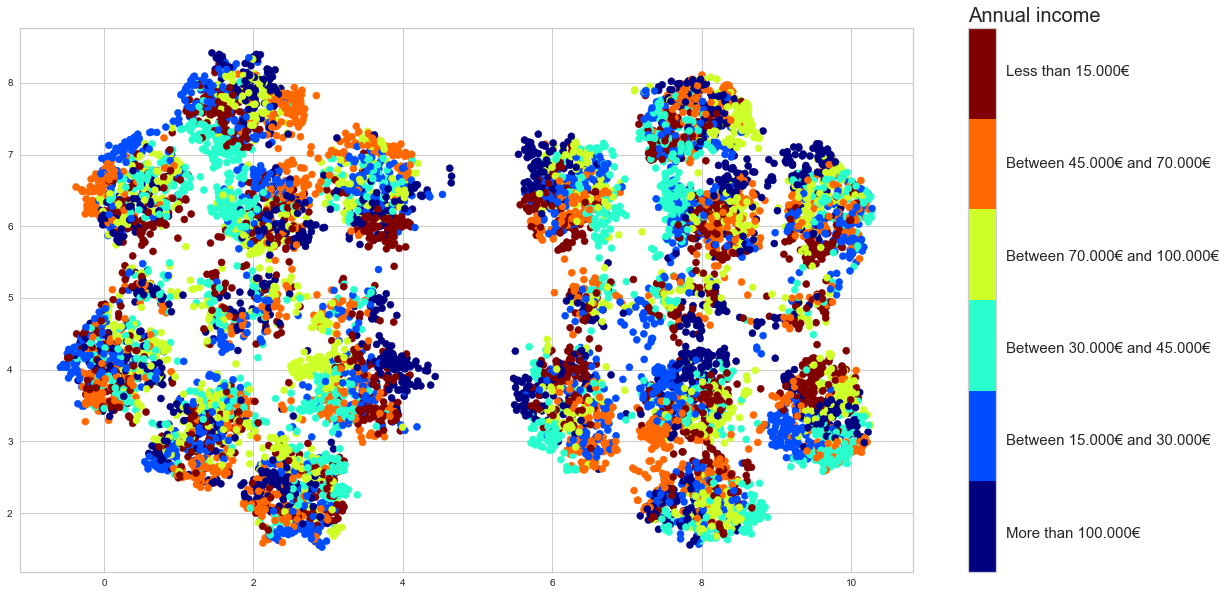

In [172]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(7, 0.35 + 0.85 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Annual income', loc = 'left', fontsize = 20)

#### Distribution by Sports practice

In [173]:
users_year = list(real_labeled_user_profile["Practice_sports"].values)

ints, gen = pd.factorize(users_year)
ints, gen

(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 array(['yes', 'no'], dtype=object))

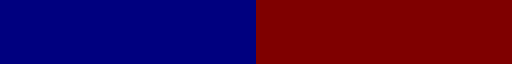

In [174]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

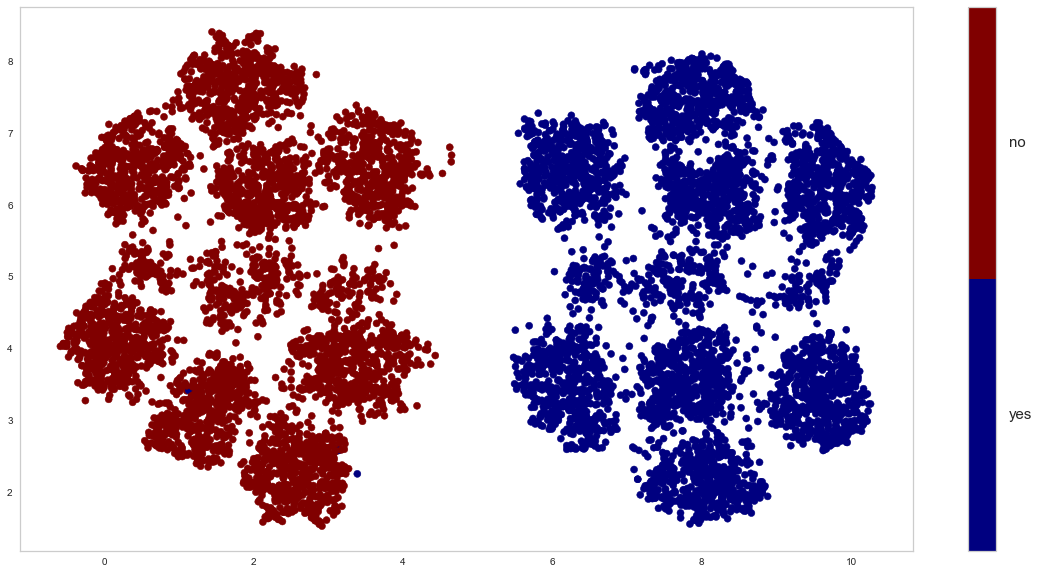

In [175]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 0.5, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1.5, 0.25 + 0.5 * j, lab, ha='left', va='center', fontsize = 15)
# cbar.ax.set_title('Sports practice', loc = 'left', fontsize = 20)
plt.grid(False)
plt.show()

### Finding the representations for the different ITEMS:

Let's create the data to input to K-means clustering model:

In [ ]:
X_train_insights = pd.DataFrame(item_id_emb)
X_train_insights.index.name = "insight_id"
X_train_insights

### K-Means clustering

Now it's time to start using the K-Means clustering technique to find the representations of the users.

#### Finding optimal number of clusters

First, we need to know how many clusters should be used to divide the users into groups:

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10,30))

visualizer.fit(X_train_insights)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
visualizer.elbow_value_

In [ ]:
n_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters = n_clusters)
labels = kmeans.fit_predict(X_train_insights)

#### Merging clusters to the data set

In [ ]:
cluster_insightids = X_train_insights.copy(deep = True).reset_index()
cluster_insightids["cluster"] = labels
cluster_insights = pd.merge(cluster_insightids, insight_dic, on = "insight_id", how = "left")
cluster_insights

#### Getting the cluster for each insight

This is just a function to retrieve the cluster where a particular user is inserted.

In [ ]:
@interact
def get_cluster(column = "cluster", insight = list(cluster_insights["insight"].values)):
    return pd.DataFrame(cluster_insights.loc[cluster_insights["insight"] == insight, column])

#### Getting the centroids for each cluster:

From now on we will be using only the `cluster_users` dataframe (the one with the users used for training). In this case, the new users are only relevant to check the results.

By getting the centroids of a cluster, we can check the average characteristics of it. Let's start by getting the centroids for every cluster:

In [ ]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns = cluster_insights.columns.drop(["insight_id", "cluster", "insight"]))

cluster_centroids["cluster"] = range(kmeans.n_clusters)

cluster_centroids

#### Getting the insights and insight categories for each cluster

With this function, we can check the user_ids of all users inside each cluster.

We can then use this to check for the insights liked by each user and try to find out which are the ones that most of them are interested in.

In [ ]:
@interact
def get_insights_and_cats(cluster = (0, kmeans.n_clusters-1, 1)):
#     cluster_insights_ = pd.merge(cluster_insights, insight_dic, on = "insight_id", how = "left")

    cluster_x_insights = pd.DataFrame(cluster_insights.loc[cluster_insights["cluster"] == cluster, ["insight_id", "insight"]])
    display(cluster_x_insights)
    print(len(cluster_x_insights))
    
    print("\033[1m\n\nINSIGHT CATEGORIES:\n")
    cluster_x_insight_cat_ids = pd.merge(cluster_x_insights, insight_features_df, on = "insight_id", how = "left")
    cluster_x_insight_cats = pd.merge(cluster_x_insight_cat_ids, insight_cat_dic, on = "cat_id", how = "left")
    cluster_x_insight_cats["category"] = cluster_x_insight_cats["category"].astype(str)
    most_liked_cats = pd.DataFrame(cluster_x_insight_cats.groupby(["cat_id", "category"])["insight_id"].count())\
    .rename(columns = {"insight_id":"count"}).sort_values("count", ascending = False).reset_index()

    insight_per_cat = insight_features_df.groupby("cat_id").count().rename(columns = {"insight_id":"n_insights"})
    most_liked_cats_4real = pd.merge(most_liked_cats, insight_per_cat, on = "cat_id")
    most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["count"] / most_liked_cats_4real["n_insights"]
    most_liked_cats_4real = most_liked_cats_4real\
    .loc[(most_liked_cats_4real["n_insights"] >= 10) & (most_liked_cats_4real["count"] >= len(cluster_x_insights) / 20)]
    
    display(most_liked_cats_4real.sort_values("likes_rate", ascending = False))
    
#     print("\033[1mFIRST APPROACH -\033[0m dropping duplicates of user_id and cat_id to get the number of users that like one category, regardless of how many insights from that category the users are interested in:\n")
#     most_liked_catids = pd.DataFrame(cluster_x_users_likes.drop_duplicates(["user_id", "cat_id"])
#     .groupby("cat_id")["user_id"].count().sort_values(ascending = False))\
#     .rename(columns = {"user_id":"n_likes"}).reset_index().head(20)
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
#     display(most_liked_cats)
    
#     print("\033[1m\n\nSECOND APPROACH -\033[0m considering all observations; the most liked categories will be the ones with the most number of insights that the users are interested in:\n")

#     most_liked_catids = pd.DataFrame(cluster_x_users_likes.groupby("cat_id")["user_id"].count()
#     .sort_values(ascending = False)).rename(columns = {"user_id":"n_likes"}).reset_index().head(20)
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
    
#     most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["n_likes"] / most_liked_cats_4real["n_insights"]
    most_liked_cats_4real = most_liked_cats_4real.loc[most_liked_cats_4real["n_insights"] >= 20]
#     display(most_liked_cats_4real.sort_values("likes_rate", ascending = False))
    
#     return pd.DataFrame(cluster_users.loc[cluster_users["cluster"] == cluster, column])

In [ ]:
pd.DataFrame(cluster_insights.loc[cluster_insights["insight"] == "Media | Art", "cluster"]).values[0][0]

In [ ]:
@interact
def get_cluster_and_insights(column = "cluster", insight = list(cluster_insights["insight"].values)):
    cluster = pd.DataFrame(cluster_insights.loc[cluster_insights["insight"] == insight, column]).values[0][0]
    display(cluster)
    
#     cluster_insights_ = pd.merge(cluster_insights, insight_dic, on = "insight_id", how = "left")

    cluster_x_insights = pd.DataFrame(cluster_insights.loc[cluster_insights["cluster"] == cluster, ["insight_id", "insight"]])
    display(cluster_x_insights)
    print(len(cluster_x_insights))
    
    print("\033[1m\n\nINSIGHT CATEGORIES:\n")
    cluster_x_insight_cat_ids = pd.merge(cluster_x_insights, insight_features_df, on = "insight_id", how = "left")
    cluster_x_insight_cats = pd.merge(cluster_x_insight_cat_ids, insight_cat_dic, on = "cat_id", how = "left")
    cluster_x_insight_cats["category"] = cluster_x_insight_cats["category"].astype(str)
    most_liked_cats = pd.DataFrame(cluster_x_insight_cats.groupby(["cat_id", "category"])["insight_id"].count())\
    .rename(columns = {"insight_id":"count"}).sort_values("count", ascending = False).reset_index()

    insight_per_cat = insight_features_df.groupby("cat_id").count().rename(columns = {"insight_id":"n_insights"})
    most_liked_cats_4real = pd.merge(most_liked_cats, insight_per_cat, on = "cat_id")
    most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["count"] / most_liked_cats_4real["n_insights"]
    most_liked_cats_4real = most_liked_cats_4real\
    .loc[(most_liked_cats_4real["n_insights"] >= 5) & (most_liked_cats_4real["count"] >= len(cluster_x_insights) / 20)]
    
    display(most_liked_cats_4real.sort_values("likes_rate", ascending = False))
    
#     print("\033[1mFIRST APPROACH -\033[0m dropping duplicates of user_id and cat_id to get the number of users that like one category, regardless of how many insights from that category the users are interested in:\n")
#     most_liked_catids = pd.DataFrame(cluster_x_users_likes.drop_duplicates(["user_id", "cat_id"])
#     .groupby("cat_id")["user_id"].count().sort_values(ascending = False))\
#     .rename(columns = {"user_id":"n_likes"}).reset_index().head(20)
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
#     display(most_liked_cats)
    
#     print("\033[1m\n\nSECOND APPROACH -\033[0m considering all observations; the most liked categories will be the ones with the most number of insights that the users are interested in:\n")

#     most_liked_catids = pd.DataFrame(cluster_x_users_likes.groupby("cat_id")["user_id"].count()
#     .sort_values(ascending = False)).rename(columns = {"user_id":"n_likes"}).reset_index().head(20)
#     most_liked_cats = pd.merge(most_liked_catids, insight_cat_dic, on = "cat_id", how = "left")
    
#     most_liked_cats_4real["likes_rate"] = most_liked_cats_4real["n_likes"] / most_liked_cats_4real["n_insights"]
    most_liked_cats_4real = most_liked_cats_4real.loc[most_liked_cats_4real["n_insights"] >= 10]
#     display(most_liked_cats_4real.sort_values("likes_rate", ascending = False))
    
#     return pd.DataFrame(cluster_users.loc[cluster_users["cluster"] == cluster, column])    
    
#     return pd.DataFrame(cluster_insights.loc[cluster_insights["insight"] == insight, column])

### Visualization of clusters - UMAP

In this section, we will present the visual results of the cluster users representation. For that, we need to reduce the dimension to 2 and after we have tried several techniques, we chose to proceed with **UMAP**.

#### Initial visualization

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()
data = cluster_insights.drop(["insight_id", "insight", "cluster"], axis = 1)

embedding = reducer.fit_transform(data)

In [ ]:
df_umap = pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1], label=labels))
groups_umap = df_umap.groupby('label')
df_umap

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, groups in groups_umap:
    r, g, b = random.random(), random.random(), random.random()
    ax.plot(groups.x, groups.y, marker='o', linestyle='', ms=10, label=name, color = (r, g, b))
ax.legend()
plt.show()

#### Distribution by category

In [ ]:
cluster_insights_cat_ids = pd.merge(cluster_insights, insight_features_df, on = "insight_id", how = "left")
cluster_insights_cats = pd.merge(cluster_insights_cat_ids, insight_cat_dic, on = "cat_id", how = "left")

In [ ]:
insight_cats = list(cluster_insights_cats["category"].values)

ints, gen = pd.factorize(insight_cats)
ints, gen

In [ ]:
from matplotlib import cm
cm.get_cmap('jet', len(gen))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], linewidths = 2, c = ints, cmap = cm.get_cmap('jet', len(gen)))

cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(10, 0.35 + 0.9 * j, lab, ha='left', va='center', fontsize = 15)
cbar.ax.set_title('Birth year', loc = 'left', fontsize = 20)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(item_id_emb)

In [ ]:
neigh.kneighbors([[-1.9319332e-03,  5.2623446e-03, -2.3873609e-03,  1.1316874e-02,
         1.1087590e-02]])

In [ ]:
insight_dic.iloc[[1, 1451,  221, 1507,  113,  323,  600,  186, 1403, 1049]]